In [1]:
import anndata as ad
import scanpy as sc
import squidpy as sq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

In [4]:
fdata = sc.read_h5ad("/home/wpy/stereoseq/20240502-SPACseq/RNA/Multitime.clustered.h5")
# fdata = sc.read_h5ad('./RNA/Multitime.filtered.guide.h5')

In [5]:
gdata = sc.read_h5ad('/home/wpy/stereoseq/20240502-SPACseq/RNA/Multitime.filtered.guide.bin100.h5')

In [4]:
# data_list = ["./RNA/B924-1.guide.bin_100.h5", "./RNA/B926-1.guide.bin_100.h5", "./RNA/B922-1.guide.bin_100.h5",
#              "./RNA/B924-2.guide.bin_100.h5", "./RNA/B926-2.guide.bin_100.h5", "./RNA/B922-2.guide.bin_100.h5"]
# marker = ["1-1", "2-1", "3-1", "1-2", "2-2", "3-2"]

In [5]:
# anndata_list = []
# for idx, data in enumerate(data_list):
#     anndata_ = sc.read_h5ad(data)
#     anndata_.obs["marker"] = marker[idx]
#     anndata_list.append(anndata_)
# guide_data = ad.concat(anndata_list, join="outer")
# guide_data.obs_names_make_unique()

In [6]:
def clean_guide_data(rnadata, guidedata):

    rnadata.obs["cov"] = [str(marker) + '_' + str(array[0]) + "-" + str(array[1]) for marker, array in zip(rnadata.obs["marker"], rnadata.obsm["spatial"])]
    guidedata.obs["cov"] = [str(marker) + '_' + str(array[0]) + "-" + str(array[1]) for marker, array in zip(guidedata.obs["marker"], guidedata.obsm["spatial"])]

    common_cov = np.intersect1d(rnadata.obs['cov'], guidedata.obs['cov'])
    guidedata.obs_names = guidedata.obs['cov']
    rnadata.obs_names = rnadata.obs['cov']

    guidedata_filtered = guidedata[common_cov].copy()
    sorted_obs_names = rnadata.obs_names.sort_values()
    guidedata_filtered = guidedata_filtered[sorted_obs_names].copy()
    rnadata = rnadata[sorted_obs_names].copy()
    missing_cov = rnadata.obs['cov'][~rnadata.obs['cov'].isin(common_cov)]
    if len(missing_cov) > 0:
        missing_obs = pd.DataFrame({'marker': [cov.split('_')[0] for cov in missing_cov]}, index=missing_cov)
        missing_obsm_spatial = np.array([[float(cov.split('_')[1].split('-')[0]), float(cov.split('_')[1].split('-')[1])] for cov in missing_cov])
        missing_X = np.zeros((len(missing_cov), guidedata.shape[1]))  # 假设 guidedata 和 rnadata 的 shape[1] 相同

        missing_guidedata = ad.AnnData(X=missing_X, obs=missing_obs, obsm={'spatial': missing_obsm_spatial})
        guidedata_filtered = guidedata_filtered.concatenate(missing_guidedata)
    return rnadata, guidedata_filtered

In [7]:
# fdata, guide_data = clean_guide_data(fdata, guide_data)

In [7]:
gdata.obs.marker = gdata.obs.marker.map({
    'B926-1': '2-1',
    'B926-2': '2-2',
    'B924-1': '1-1',
    'B924-2': '1-2',
    'B922-1': '3-1',
    'B922-2': '3-2'
})

In [9]:
# guide_data[:, 'sgNTC'].X = guide_data[:, ['sgNTC', 'sgnon-targeting_2_gene', 'sgnon-targeting_1_gene']].X.sum(axis=1)

In [10]:
# guide_data = guide_data[:, :-2].copy()

In [11]:
# guide_data.write_h5ad("./RNA/Multitime.guide.h5")

In [8]:
fdata.obs['coord_x'] = fdata.obsm['spatial'][:, 0] // 100 * 100
fdata.obs['coord_y'] = fdata.obsm['spatial'][:, 1] // 100 * 100

gdata.obs['coord_x'] = gdata.obsm['spatial'][:, 0] // 100 * 100
gdata.obs['coord_y'] = gdata.obsm['spatial'][:, 1] // 100 * 100
fdata.obs_names = [str(marker) + '_' + str(x) + '_' + str(y) for marker, x, y in zip(fdata.obs['marker'], fdata.obs['coord_x'], fdata.obs['coord_y'])]
gdata.obs_names = [str(marker) + '_' + str(x) + '_' + str(y) for marker, x, y in zip(gdata.obs['marker'], gdata.obs['coord_x'], gdata.obs['coord_y'])]

common_bins = np.intersect1d(fdata.obs_names, gdata.obs_names)
fdata = fdata[common_bins].copy()
gdata = gdata[common_bins].copy()

In [9]:
gdata.obs["cluster"] = fdata.obs["cluster_cellcharter_givenk"].tolist()

In [14]:
# gdata.write_h5ad('./RNA/Multitime.filtered.guide.fixed.h5')

In [15]:
# gdata = sc.read_h5ad('./RNA/Multitime.filtered.guide.fixed.h5')

In [11]:
def combine_guide_replicates(gdata):
    """
    Usage:
        combine guide replicates in <gdata> to a single gene name
    Return:
        single gene name anndata
    """
    sgs = gdata.var_names.str.split('_', n=1).str[0]
    sgs_grouped = pd.DataFrame(gdata.X.toarray(), columns=gdata.var_names)
    sgs_grouped = sgs_grouped.groupby(sgs, axis=1).sum()

    cgdata = ad.AnnData(sgs_grouped, obs=gdata.obs, var=pd.DataFrame(index=sgs_grouped.columns))
    cgdata.obsm['spatial'] = gdata.obsm['spatial']
    return cgdata
gdata = combine_guide_replicates(gdata)

/tmp/ipykernel_108690/3691933421.py:10: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  sgs_grouped = sgs_grouped.groupby(sgs, axis=1).sum()


Text(0.5, 1.0, 'KDE of Spp1')

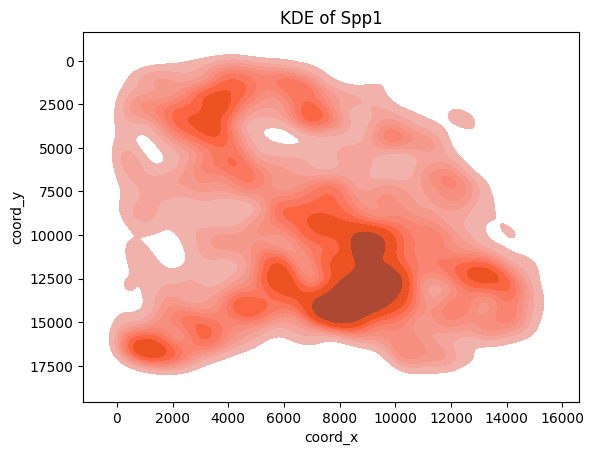

In [36]:
fdata_ = fdata[fdata.obs.marker == '2-1']
fdata_ = fdata_[fdata_[:, 'Spp1'].X > 1]
s_df = pd.DataFrame({
    'coord_x': fdata_.obsm['spatial'][:, 0],
    'coord_y': fdata_.obsm['spatial'][:, 1],
    'hue': [1] * fdata_.shape[0]
})

fig, ax = plt.subplots(1, 1)
# sq.pl.spatial_scatter(fdata_, color='shannon', shape=None, size=0, library_id='spatial', ax=ax)
sns.kdeplot(s_df, x='coord_x', y='coord_y', fill=True, bw_adjust=0.5, ax=ax, alpha=1, hue='hue', palette='Reds', legend=False)
plt.gca().invert_yaxis()
plt.title('KDE of Spp1')

In [11]:
sample = '3-2'
(gdata[gdata.obs.marker == sample].obsm['spatial'][:, 0].max() - gdata[gdata.obs.marker == sample].obsm['spatial'][:, 0].min())

17564

In [15]:
(17564 * 0.5 * 1e-6) / 43.901 * 5

0.0010002050067196646

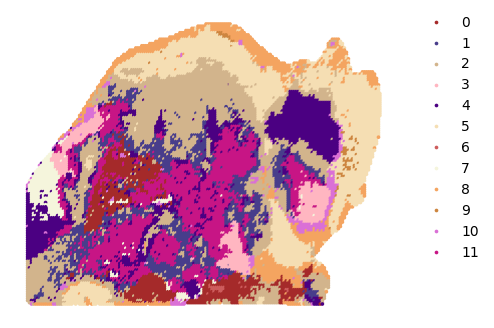

In [84]:
# 自定义颜色映射
from matplotlib.colors import ListedColormap
sample = '3-2'

gdata.obs.cluster = gdata.obs.cluster.astype('category')

# 定义自定义颜色
custom_colors = ['brown', # EMT
                 'darkslateblue', # Tumor APC
                 'tan', # Fibro
                 'lightpink', # APC
                 'indigo', # Fibro Tumor
                 'wheat', # Fibro
                 'indianred', # Necrosis
                 'beige', # Fibro
                 'sandybrown', # Fibro
                 'peru', # Fibro Tumor
                 'orchid', # APC
                 'mediumvioletred', # Tumor
]
custom_cmap = ListedColormap(custom_colors)

# 绘制空间散点图，不显示图例
_, ax = plt.subplots(1, 1, figsize=((gdata[gdata.obs.marker == sample].obsm['spatial'][:, 0].max() - gdata[gdata.obs.marker == sample].obsm['spatial'][:, 0].min()) / 300 // 10,
                                    (gdata[gdata.obs.marker == sample].obsm['spatial'][:, 1].max() - gdata[gdata.obs.marker == sample].obsm['spatial'][:, 1].min()) / 300 // 10))

sns.scatterplot(
    x=gdata[gdata.obs.marker == sample].obsm['spatial'][:, 0], 
    y=gdata[gdata.obs.marker == sample].obsm['spatial'][:, 1], 
    hue=gdata[gdata.obs.marker == sample].obs['cluster'], 
    palette=custom_colors,  # 使用自定义颜色映射
    s=7,
    alpha=1, 
    ax=ax,
    legend=True,
    edgecolor='none',
    marker='o'
)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., frameon=False)  # 调整Legend对应的label的大小
sns.despine(left=True, bottom=True)
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([])
plt.gca().invert_yaxis()
plt.title('')

plt.rcParams['pdf.fonttype']=42
plt.savefig(f"./plots/cluster_plot_raw_{sample}.pdf", format="pdf", bbox_inches='tight')
plt.show()

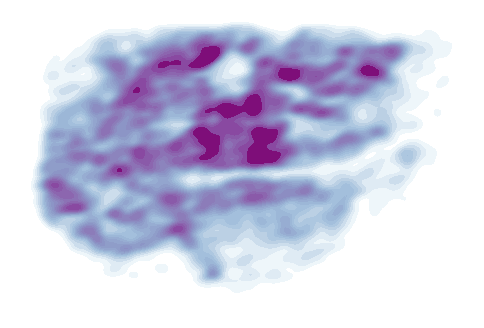

In [33]:
plot_data = gdata[gdata.obs.marker == '1-2']
plt.figure(figsize=((plot_data.obsm['spatial'][:, 0].max() - plot_data.obsm['spatial'][:, 0].min()) // 3000,
                     (plot_data.obsm['spatial'][:, 1].max() - plot_data.obsm['spatial'][:, 1].min()) // 3000))
sns.kdeplot(x=plot_data.obsm['spatial'][:, 0], y=plot_data.obsm['spatial'][:, 1], weights=np.array(plot_data.X.sum(axis=1)).flatten(),
            fill=True, bw_adjust=0.3, alpha=1, levels=20, legend=False, cmap='BuPu')

sns.despine(left=True, bottom=True)
plt.xlabel('')
plt.ylabel('')
plt.title('')
plt.gca().invert_yaxis()
plt.xticks([])
plt.yticks([])

plt.rcParams['pdf.fonttype']=42
plt.savefig("./plots/guide_kde_plot_raw_1-2.pdf", format="pdf", bbox_inches='tight')
plt.show()

/tmp/ipykernel_69852/2353394753.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cdf = pd.concat([pd.DataFrame(gdata.X, columns=gdata.var_names, index=gdata.obs_names), gdata.obs.marker], axis=1).groupby('marker').sum().T


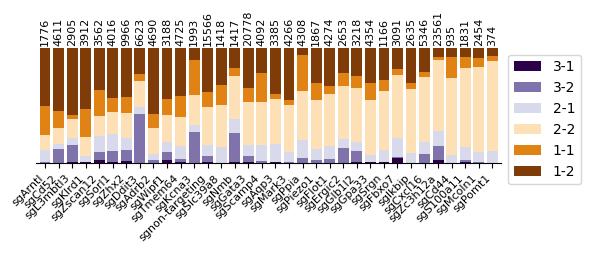

In [17]:
cdf = pd.concat([pd.DataFrame(gdata.X, columns=gdata.var_names, index=gdata.obs_names), gdata.obs.marker], axis=1).groupby('marker').sum().T
cdf = cdf.div(cdf.sum(axis=1), axis=0)
cdf = cdf.loc[:, ['3-1', '3-2', '2-1', '2-2', '1-1', '1-2']]

# 按照guide从低到高排序
cdf_sorted = cdf.loc[cdf['2-2'].sort_values(ascending=True).index, :]

# 绘制堆叠条形图并调整legend位置
_, ax = plt.subplots(1, 1, figsize=(6, 1.5))
cdf_sorted.plot(kind='bar', stacked=True, cmap='PuOr_r', legend=True, position=0, width=0.8, ax=ax)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # 将legend移动到左侧
sns.despine(left=True, bottom=False)
plt.yticks([])
plt.ylim([0, 1])
plt.xlabel('')
plt.ylabel('')
plt.title('')
plt.xticks(np.arange(len(cdf_sorted.index)) + 0.4, cdf_sorted.index, rotation=45, ha='right', fontsize=8)
for i in range(len(cdf_sorted.index)):
    ax.text(i+0.4, 1.02, str(gdata[:, cdf_sorted.index[i]].X.sum(axis=0)[0]), ha='center', va='bottom', fontsize=8, rotation=90)
plt.rcParams['pdf.fonttype']=42
plt.savefig("./plots/guide_proportion_barplot.pdf", format="pdf", bbox_inches='tight')
plt.show()

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/plotting/_utils.py:432: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/tmp/ipykernel_36418/2899982378.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap("jet")


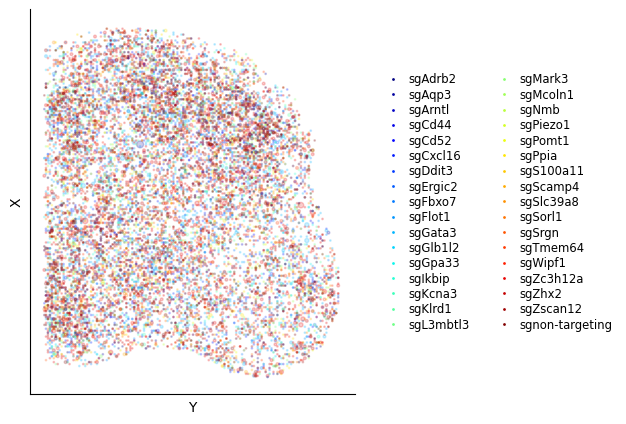

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import ticker
import matplotlib.cm as cm

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

# Convert cluster to a categorical type
gdata.obs.cluster = gdata.obs.cluster.astype('category')

# Plot spatial scatter, with no legend displayed
sq.pl.spatial_scatter(
    gdata[gdata.obs.marker == '2-1'], 
    color=['marker'], 
    library_key='marker',  
    size=50, 
    img=None,
    spatial_key='spatial',
    palette='Grays',
    figsize=(15, 15),
    ncols=2,
    shape=None,
    ax=ax,
    alpha=0.05
)

# Import utilities and colormap
from bin import utils

# Get the colormap and generate colors for the guides
colormap = cm.get_cmap("jet")
colors = colormap(np.linspace(0, 1, len(gdata.var_names)))

# Plot dots with custom colors
for idx, guide in enumerate(gdata.var_names):
    utils.plot_dot(gdata[gdata.obs.marker == '2-1', :], guide, ax=ax, color=colors[idx])

# Manually create legend handles using Line2D
legend_handles = [Line2D([0], [0], marker='o', color='w', label=guide, markerfacecolor=colors[idx], markersize=3)
                  for idx, guide in enumerate(gdata.var_names)]

# Remove spines using seaborn
sns.despine()

# Set axis labels
plt.title('')
plt.xlabel('Y')
plt.ylabel('X')

# Create a legend only for plot_dot with 2 columns and place it on the right side
plt.legend(
    handles=legend_handles,  # Use manually created legend handles
    loc='center left',  # Position to the right side of the plot
    bbox_to_anchor=(1.05, 0.5),  # Right of the plot, vertically centered
    ncol=2,  # Arrange the legend in 2 columns
    frameon=False,  # Remove the legend's border
    fontsize='small',  # Reduce the font size
    handletextpad=0.3,  # Reduce space between the legend symbol and the text
    labelspacing=0.2  # Reduce space between the lines in the legend
)

plt.rcParams['pdf.fonttype']=42
plt.savefig("./plots/Cluster_Guide_Combined_B926_1.pdf", format="pdf", bbox_inches='tight')
plt.show()

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. 

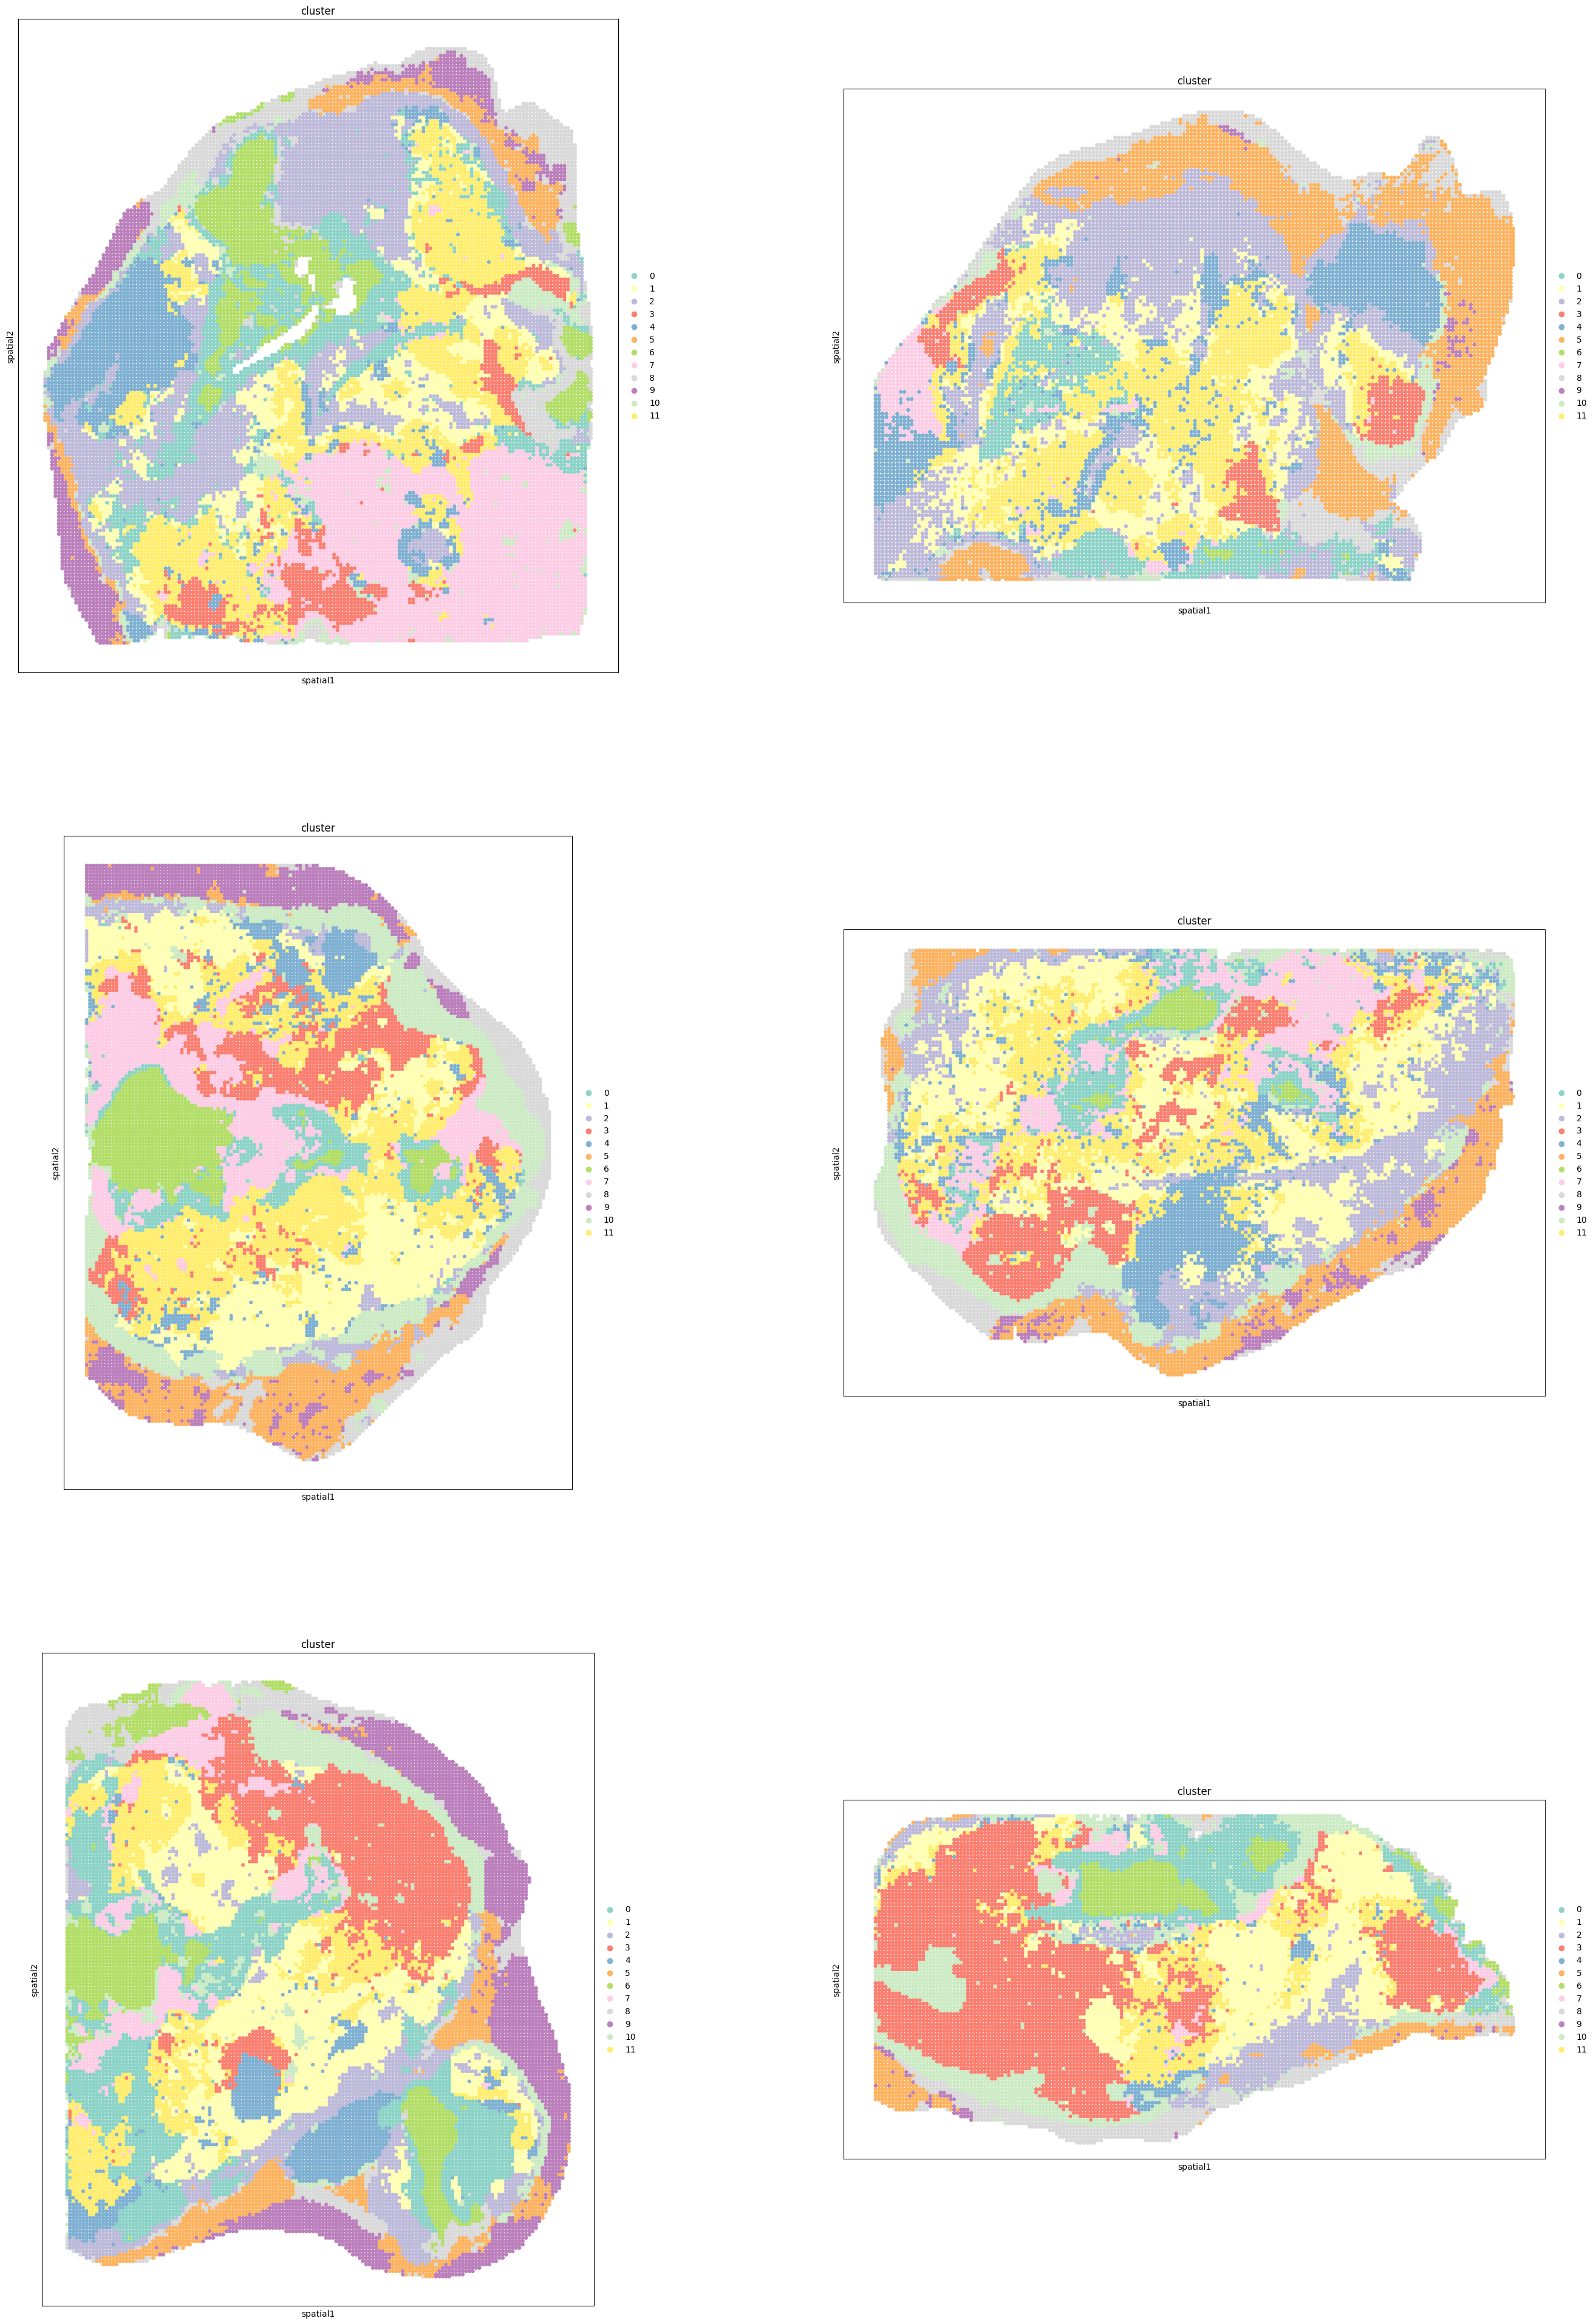

In [15]:
gdata.obs.cluster = gdata.obs.cluster.astype('category')
sq.pl.spatial_scatter(
    gdata, 
    color=['cluster'], 
    library_key='marker',  
    size=50, 
    img=None,
    spatial_key='spatial',
    palette='Set3',
    figsize=(15,15),
    ncols=2,
    shape=None
)

In [64]:
result_df = pd.DataFrame()
for marker in ['1-1', '1-2', '2-1', '2-2', '3-1', '3-2']:
    guide_data = gdata[gdata.obs.marker == marker].copy()
    c_df = pd.DataFrame(guide_data.X, columns=guide_data.var_names)
    c_df["cluster"] = guide_data.obs["cluster"].tolist()
    c_df = c_df.groupby(["cluster"]).sum()

    from scipy.stats import chi2_contingency
    from scipy.spatial.distance import cosine
    m_df = c_df.T
    ntc_cnt = m_df.loc['sgnon-targeting'].sum()
    m_df = m_df.div(m_df.sum(axis=1), axis=0) * ntc_cnt
    chi_dict = {}
    for guide in gdata.var_names:
        if m_df.loc[guide].sum() == 0:
            chi_dict[guide] = 1
            continue
        if guide == 'sgnon-targeting': continue
        chi_dict[guide] = cosine(m_df.loc['sgnon-targeting'], m_df.loc[guide])

    pdf = pd.DataFrame(chi_dict, index=['Cosine Similarity']).T.sort_values(by='Cosine Similarity', ascending=False).reset_index()
    pdf = pdf.sort_values(by='Cosine Similarity', ascending=False)
    pdf['rank'] = np.arange(len(pdf))
    pdf.columns = ['guide', f'similarity_{marker}', f'rank_{marker}']
    pdf.set_index('guide', inplace=True)
    result_df = pd.concat([result_df, pdf], axis=1)
result_df = result_df.loc[:, result_df.columns.str.startswith('rank')]
result_df['mean_rank'] = result_df.mean(axis=1)
result_df.reset_index(inplace=True)
result_df.sort_values(by='mean_rank', ascending=True, inplace=True)

/tmp/ipykernel_108690/2822455637.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(result_df, x='guide', y='mean_rank', palette='Blues')


Text(0.5, 0, 'Guide')

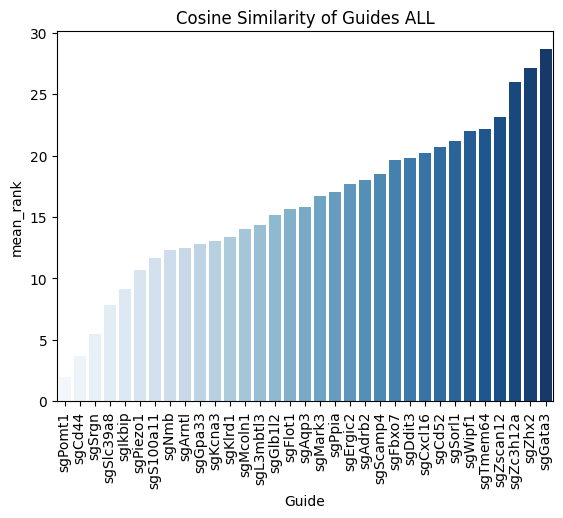

In [65]:
sns.barplot(result_df, x='guide', y='mean_rank', palette='Blues')
plt.xticks(rotation=90)
plt.title('Cosine Similarity of Guides ALL')
plt.xlabel('Guide')

In [37]:
guide_data = gdata.copy()

In [38]:
c_df = pd.DataFrame(guide_data.X, columns=guide_data.var_names)
c_df["cluster"] = guide_data.obs["cluster"].tolist()
c_df = c_df.groupby(["cluster"]).sum()

p_df = c_df.T.div(c_df.T.sum(axis=1), axis=0)
p_df = p_df.div(p_df.loc['sgnon-targeting', :], axis=1)
p_df = np.log10(p_df)

p_df.head()

cluster        0         1         2         3         4         5         6   \
sgAdrb2 -0.010001  0.033404  0.003047 -0.053276  0.072434  0.042835 -0.188690   
sgAqp3   0.026585 -0.015258 -0.037591  0.069656 -0.015288 -0.098097 -0.017917   
sgArntl  0.009749  0.077372  0.020676 -0.198876  0.144757  0.014882  0.019160   
sgCd44  -0.097551 -0.050004 -0.193608  0.134474 -0.139043 -0.192563 -0.023442   
sgCd52  -0.025747  0.046879  0.116614 -0.187644  0.100353  0.125178 -0.119566   

cluster        7         8         9         10        11  
sgAdrb2  0.064394 -0.053403  0.025541 -0.005435  0.002490  
sgAqp3  -0.074202 -0.020128 -0.054693  0.030774 -0.056555  
sgArntl  0.052330 -0.055766  0.108917  0.025654  0.033013  
sgCd44  -0.205281  0.207626 -0.124335  0.161761 -0.099868  
sgCd52   0.106236 -0.046025  0.017314 -0.087668  0.082210

In [43]:
modeul_dict = {
    'Module 1': ['sgPomt1', 'sgCd44', 'sgMcoln1', 'sgS100a11'],
    'Module 2': ['sgDdit3', 'sgKcna3', 'sgCd52', 'sgL3mbtl3', 'sgAdrb2', 'sgSorl1', 'sgZhx2', 'sgWipf1', 'sgZscan12', 'sgTmem64', 'sgArntl', 'sgKlrd1'],
    'Module 3': ['sgNmb', 'sgPpia', 'sgScamp4', 'sgZc3h12a', 'sgFbxo7', 'sgCxcl16', 'sgIkbip', 'sgGpa33', 'sgPiezo1', 'sgSrgn', 'sgMark3', 'sgSlc39a8', 'sgErgic2', 'sgGata3', 'sgGlb1l2', 'sgAqp3', 'sgFlot1'],
}
cluster_seq = [3, 8, 6, 0, 10, 9, 2, 5, 4, 7, 1, 11]

FileNotFoundError: [Errno 2] No such file or directory: './plots/cluster_guide_proportion_radar.pdf'

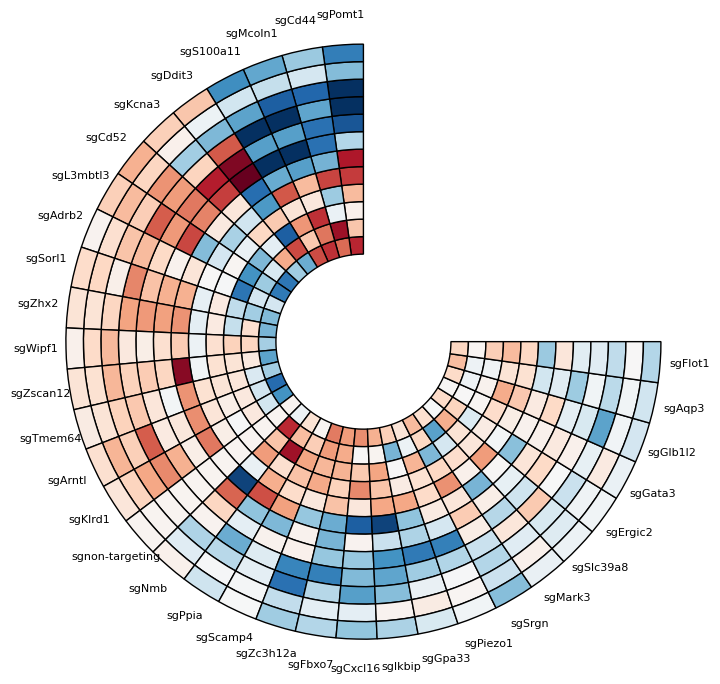

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8), subplot_kw={'projection': 'polar'})

cmap = plt.colormaps['RdBu_r']

# sorted_guides = p_df.index[np.argsort(p_df.loc[:, 3].values)[::-1]]

guide_seq = modeul_dict['Module 1'] + modeul_dict['Module 2'] + ['sgnon-targeting'] + modeul_dict['Module 3']
mean_val = np.mean(p_df.loc[guide_seq, :].values)
# p_df = p_df.loc[:, [3, 10, 0, 6, 8, 11, 1, 9, 4, 7, 5, 2]]
p_df = p_df.loc[:, cluster_seq]
radius = 1
width = 0.2

angle = 1.5 * np.pi / len(p_df.index)
angles = np.linspace(0.5 * np.pi + angle / 2, 2 * np.pi + angle / 2, len(p_df.index), endpoint=False)
for cluster in ['None'] * 0 + list(p_df.columns):
    if cluster != 'None':
        guide_colors = cmap((p_df.loc[guide_seq, cluster].values - mean_val) * 2 + 0.5)
        # guide_colors = cmap((p_df.loc[guide_seq, cluster].values - mean_val))
        bars = ax.bar(x=angles, height=width, width=angle, color=guide_colors, edgecolor='black', bottom=radius, alpha=1)  # 添加黑色网框
    else: 
        bars = ax.bar(x=angles, height=width, width=angle, color='none', edgecolor='black', bottom=radius)  # 添加黑色网框
    radius = radius + width

ax.spines['polar'].set_visible(False)  # 去除边框
ax.set_xticks(angles, guide_seq, rotation=0, ha='center', fontsize=8)
# ax.set_yticks(list(np.linspace(6 * width, 18 * width, 12)))
ax.set_yticks([])
ax.grid(False)  # 去除grid线

# plt.xlim([0.5 * np.pi, 2 * np.pi])
# plt.ylim([0, 1])
# plt.rcParams['pdf.fonttype']=42
plt.savefig("./plots/cluster_guide_proportion_radar.pdf", format="pdf", bbox_inches='tight')
plt.show()

In [39]:
from scipy.stats import chi2_contingency
from scipy.spatial.distance import cosine
m_df = c_df.T
ntc_cnt = m_df.loc['sgnon-targeting'].sum()
m_df = m_df.div(m_df.sum(axis=1), axis=0) * ntc_cnt
chi_dict = {}
for guide in gdata.var_names:
    if m_df.loc[guide].sum() == 0:
        chi_dict[guide] = 1
        continue
    if guide == 'sgnon-targeting': continue
    # chi_dict[guide] = chi2_contingency(m_df.loc[['sgnon-targeting', guide]].T).pvalue
    chi_dict[guide] = cosine(m_df.loc['sgnon-targeting'], m_df.loc[guide])

/tmp/ipykernel_108690/746880726.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(pdf, x='index', y='Cosine Similarity', palette='Blues')


Text(0.5, 0, 'Guide')

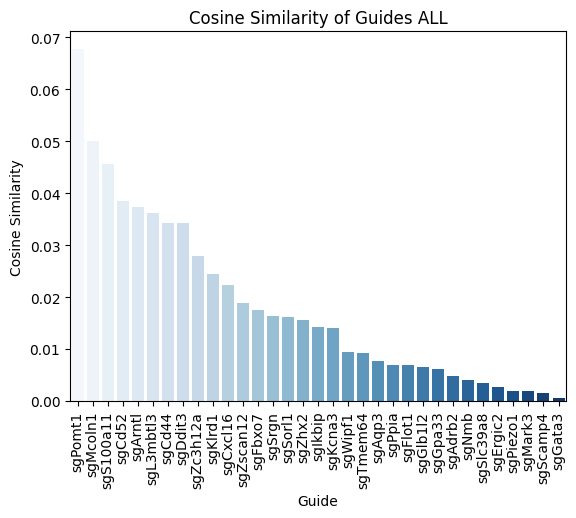

In [41]:
pdf = pd.DataFrame(chi_dict, index=['Cosine Similarity']).T.sort_values(by='Cosine Similarity', ascending=False).reset_index()
# plt.figure(figsize=(12, 6))
sns.barplot(pdf, x='index', y='Cosine Similarity', palette='Blues')
plt.xticks(rotation=90)
# plt.gca().set_yscale('log')
plt.title('Cosine Similarity of Guides ALL')
plt.xlabel('Guide')

In [22]:
from scipy.stats import chi2_contingency

In [29]:
p_df = pd.DataFrame()
flag = False
for guide in np.unique(c_df.columns.get_level_values(0)):
    sum_v = c_df[guide].sum()
    p_v = (c_df[guide].T / sum_v).T
    if not flag:
        p_df = pd.concat([p_df, p_v.reset_index().melt(id_vars="marker")], axis=1)
        flag = True
    else: p_df = pd.concat([p_df, p_v.reset_index().melt(id_vars="marker").value], axis=1)
pp_df = p_df.iloc[:, 2:]
pp_df.columns = np.unique(c_df.columns.get_level_values(0))
pp_df.index = [str(marker) + "_" + str(cluster) for marker, cluster in zip(p_df["marker"], p_df["cluster"])]

KeyError: "The following id_vars or value_vars are not present in the DataFrame: ['marker']"

In [11]:
pp_df.fillna(0, inplace=True)

In [12]:
from scipy.stats import entropy
ent = {}
for guide in pp_df.columns:
    ent[guide] = entropy(pp_df[guide])
df = pd.DataFrame(ent, index=['Shannon Entropy']).T.reset_index().sort_values(by='Shannon Entropy')
plt.figure(figsize=(12, 6))
sns.barplot(df, x='index', y='Shannon Entropy', palette='RdBu_r')
plt.xticks(rotation=90)
plt.ylim([2.0, 4.0])
plt.title('Cluster Shannon Entropy of Guides')
plt.xlabel('Guide')

NameError: name 'pp_df' is not defined

In [12]:
ntc_df = pp_df.T - pp_df.loc[:, "sgnon-targeting"]

In [13]:
pd.DataFrame(ntc_df.loc['sgCd44_2_gene'] + pp_df.loc[:, 'sgnon-targeting']).sort_index()[-12:]

0
3-2_0   0.0
3-2_1   0.0
3-2_10  0.0
3-2_11  0.0
3-2_2   0.0
3-2_3   1.0
3-2_4   0.0
3-2_5   0.0
3-2_6   0.0
3-2_7   0.0
3-2_8   0.0
3-2_9   0.0

<Figure size 640x480 with 0 Axes>

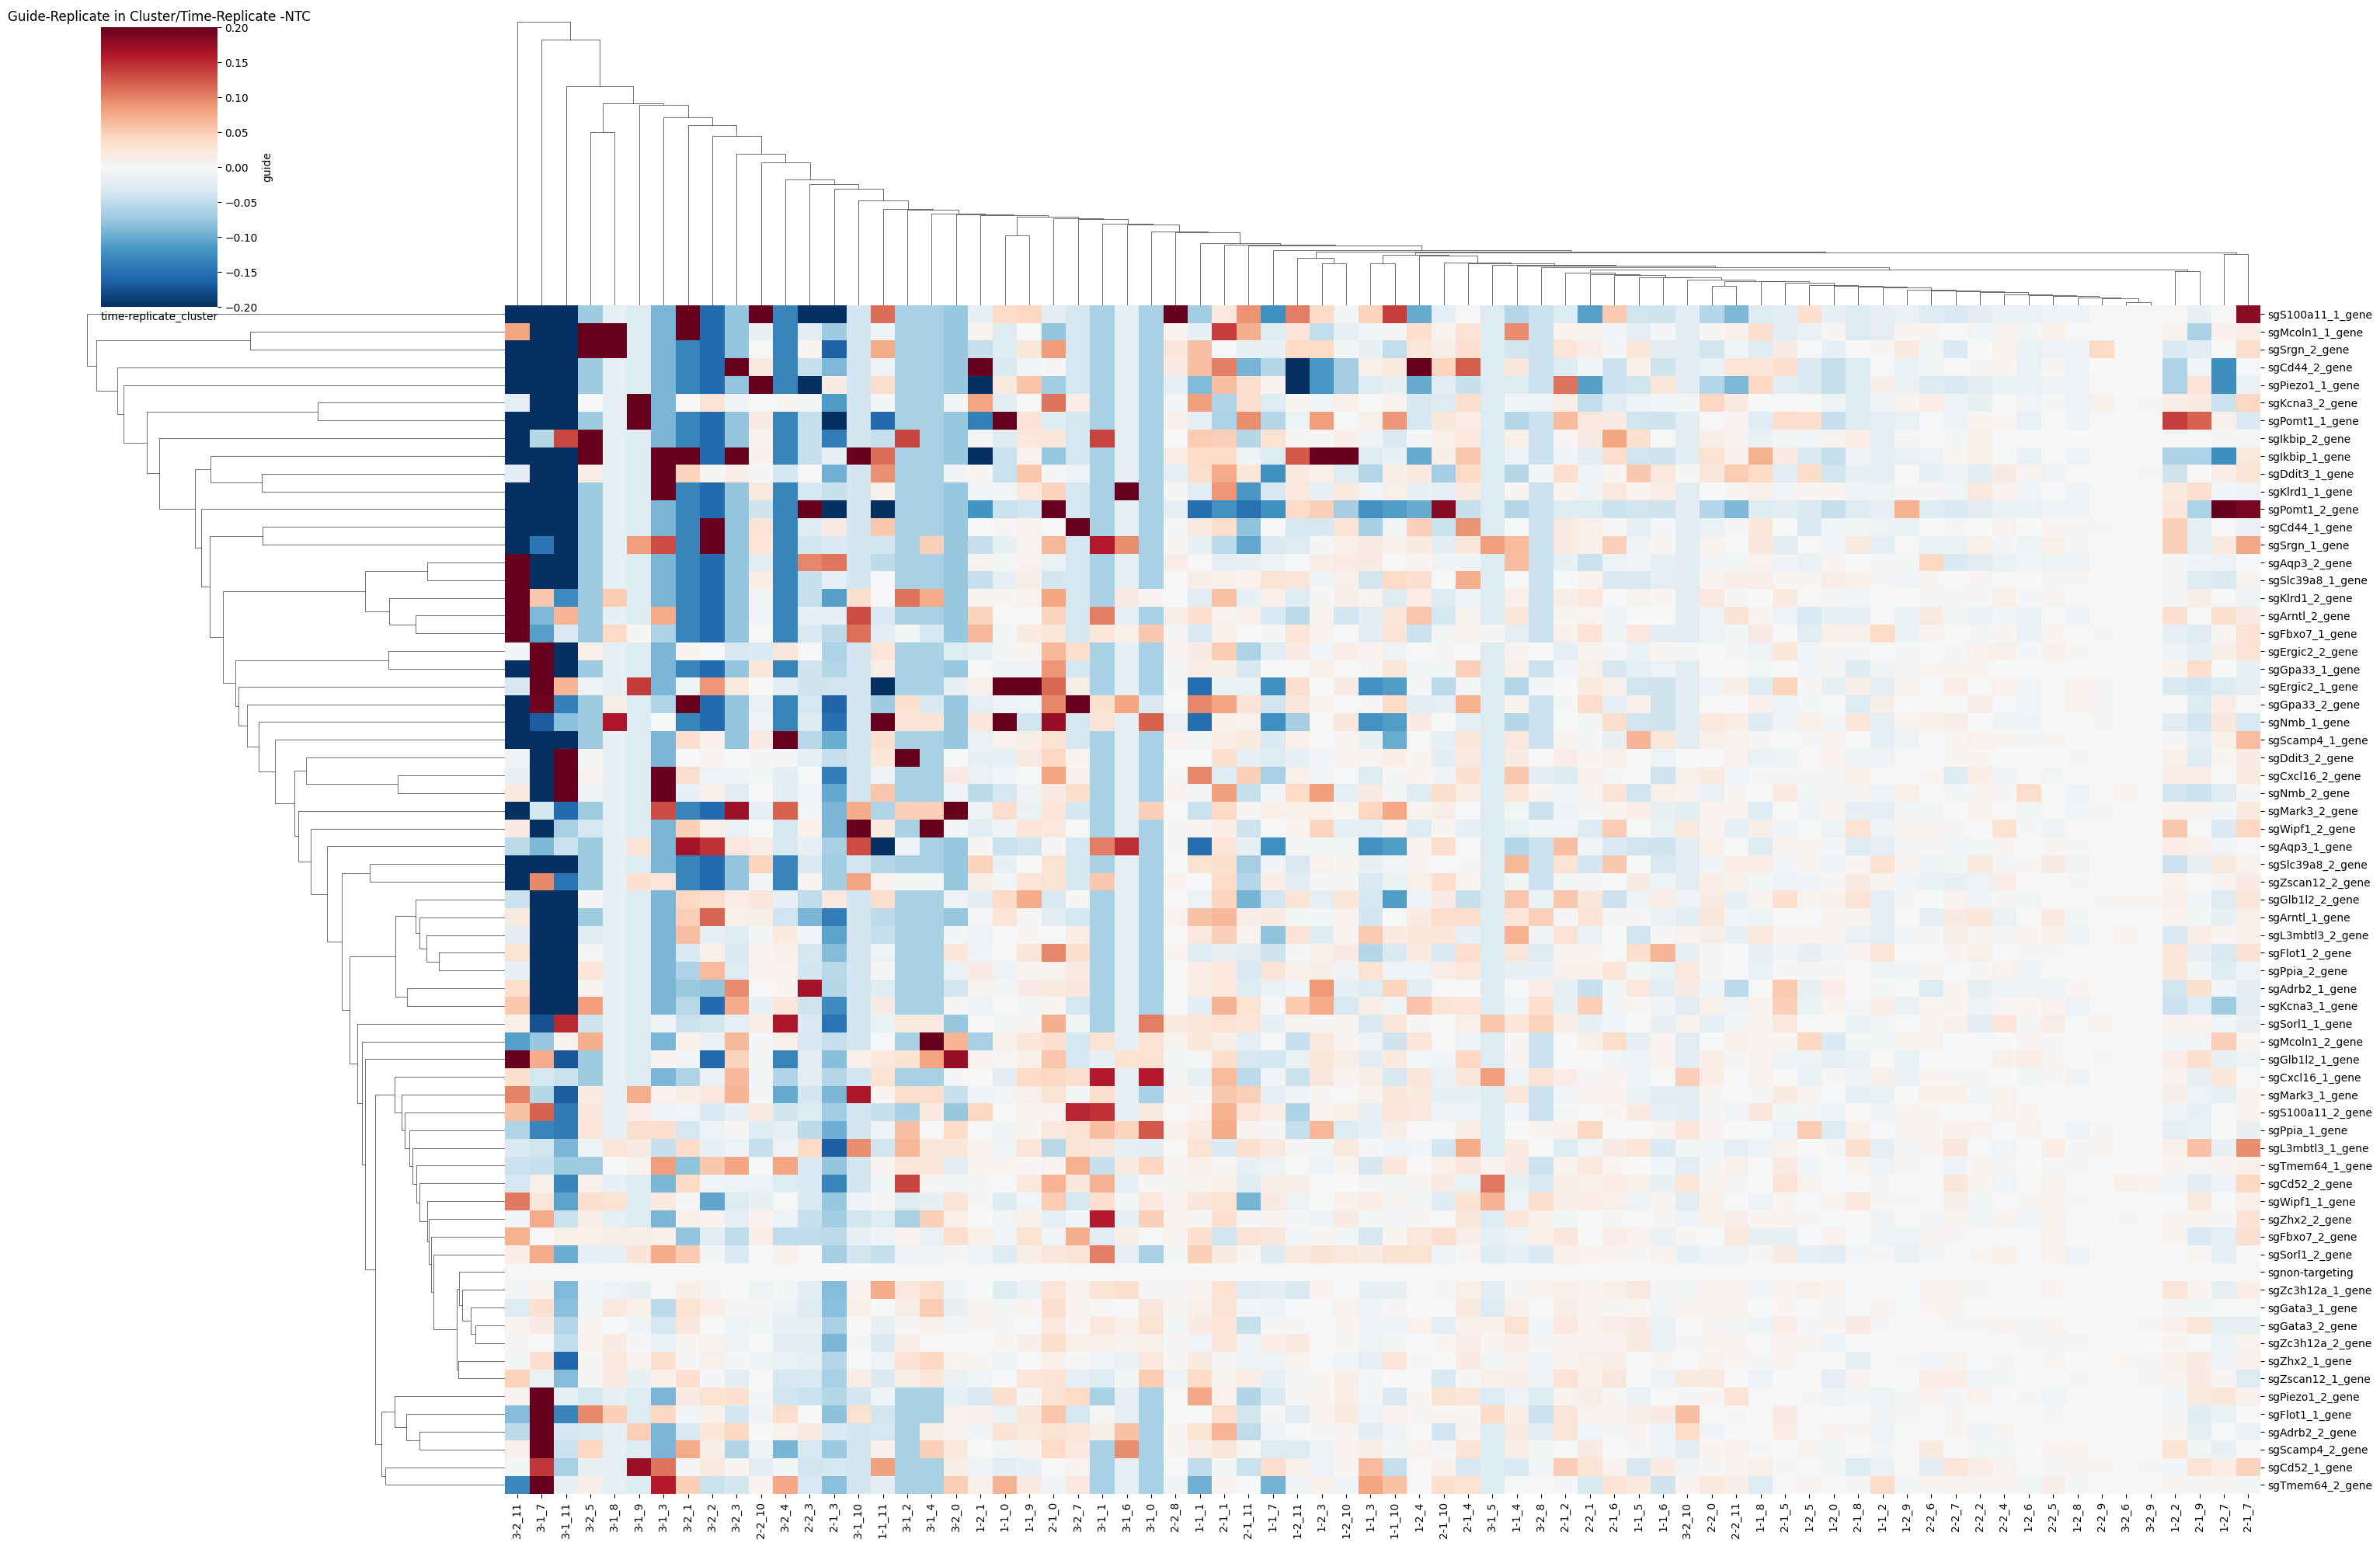

In [14]:
plt.figure()
sns.clustermap(ntc_df, cmap="RdBu_r", vmax=0.2, vmin=-0.2, figsize=(30, 20))

plt.title("Guide-Replicate in Cluster/Time-Replicate -NTC")
plt.ylabel("guide")
plt.xlabel("time-replicate_cluster")
plt.show()

In [42]:
gdata[gdata.obs.marker == '3-2', 'sgCd44_2_gene'].X.sum()

1

In [64]:
pd.DataFrame(guide_data[guide_data.obs.marker =='2-1'].X.toarray(), columns=guide_data.var_names).melt().groupby('value')

In [55]:
for marker in guide_data.obs.marker.unique():
    pd.DataFrame(guide_data[guide_data.obs.marker == marker].X)

1-1
1-2
2-1
2-2
3-1
3-2


In [41]:
guide_data = gdata.copy()

c_df = pd.DataFrame(guide_data.X.toarray(), columns=guide_data.var_names)
c_df["cluster"] = guide_data.obs["cluster"].tolist()
c_df = c_df.groupby(["cluster"]).sum()

p_df = pd.DataFrame()
for guide in np.unique(c_df.columns):
    sum_v = c_df[guide].sum()
    p_v = (c_df[guide].T / sum_v).T
    p_df = pd.concat([p_df, p_v], axis=1)

p_df.columns = np.unique(c_df.columns)

ntc_df = p_df.T - p_df.loc[:, "sgnon-targeting"]

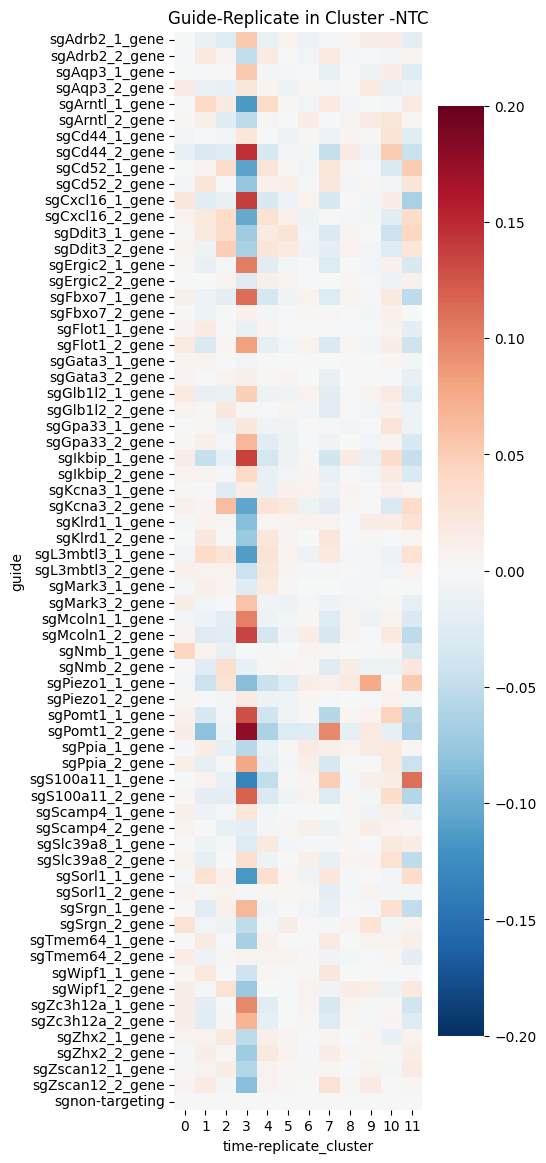

In [28]:
plt.figure(figsize=(4, 14))
sns.heatmap(ntc_df, cmap="RdBu_r", vmax=0.2, vmin=-0.2)

plt.title("Guide-Replicate in Cluster -NTC")
plt.ylabel("guide")
plt.xlabel("time-replicate_cluster")
plt.show()

In [17]:
sgs = guide_data.var_names.str.split('_', n=1).str[0]
sgs_grouped = pd.DataFrame(guide_data.X.toarray(), columns=guide_data.var_names)
sgs_grouped = sgs_grouped.groupby(sgs, axis=1).sum()
sgdata = ad.AnnData(sgs_grouped, obs=guide_data.obs, var=pd.DataFrame(index=sgs_grouped.columns))
sgdata.obsm['spatial'] = guide_data.obsm['spatial']
gdata = sgdata.copy()

/tmp/ipykernel_25805/3092818934.py:3: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  sgs_grouped = sgs_grouped.groupby(sgs, axis=1).sum()


In [18]:
c_df = pd.DataFrame(gdata.X, columns=gdata.var_names)
c_df["marker"] = gdata.obs["marker"].tolist()
c_df["cluster"] = gdata.obs["cluster"].tolist()
c_df = c_df.groupby(["marker", "cluster"]).sum().unstack()

p_df = pd.DataFrame()
flag = False
for guide in np.unique(c_df.columns.get_level_values(0)):
    sum_v = c_df[guide].sum(axis=1)
    p_v = (c_df[guide].T / sum_v).T
    if not flag:
        p_df = pd.concat([p_df, p_v.reset_index().melt(id_vars="marker")], axis=1)
        flag = True
    else: p_df = pd.concat([p_df, p_v.reset_index().melt(id_vars="marker").value], axis=1)
pp_df = p_df.iloc[:, 2:]
pp_df.columns = np.unique(c_df.columns.get_level_values(0))
pp_df.index = [str(marker) + "_" + str(cluster) for marker, cluster in zip(p_df["marker"], p_df["cluster"])]

ntc_df = pp_df.T - pp_df.loc[:, "sgnon-targeting"]

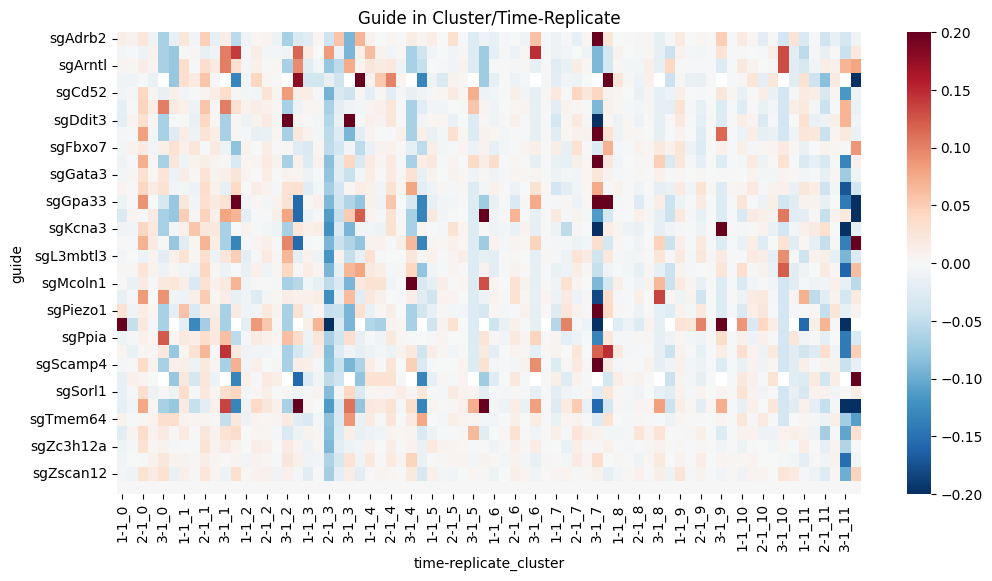

In [23]:
plt.figure(figsize=(12, 6))
sns.heatmap(ntc_df, cmap="RdBu_r", vmax=0.2, vmin=-0.2)

plt.title("Guide in Cluster/Time-Replicate")
plt.ylabel("guide")
plt.xlabel("time-replicate_cluster")
plt.show()

In [24]:
from matplotlib.gridspec import GridSpec

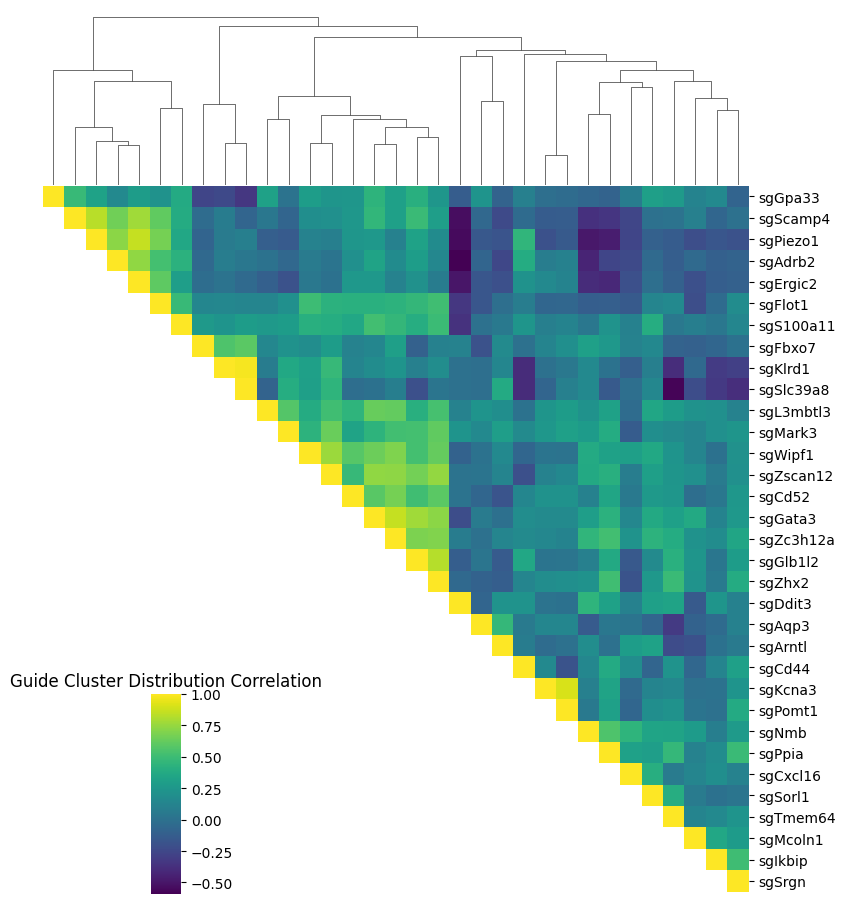

In [25]:
clean_ntc_df = ntc_df[ntc_df.index != "sgnon-targeting"]
correlation_matrix = clean_ntc_df.T.corr()

# 使用 seaborn 的 clustermap 绘制热图，并只对 x 轴进行聚类
g = sns.clustermap(correlation_matrix, cmap='viridis', figsize=(10, 10), col_cluster=True, row_cluster=True)

# 只显示右上角部分的矩阵，并保留颜色条
g.ax_row_dendrogram.set_visible(False)

# 获取聚类后的索引顺序
clustered_index = g.dendrogram_row.reordered_ind
clustered_columns = g.dendrogram_col.reordered_ind

# 创建一个新的掩码，只显示右上角部分
mask = np.zeros_like(correlation_matrix, dtype=bool)
mask[np.tril_indices_from(mask, -1)] = True

for i in range(len(mask)):
    for j in range(len(mask)):
        if mask[clustered_index[i], clustered_columns[j]]:
            g.ax_heatmap.add_patch(plt.Rectangle((clustered_columns[j], clustered_index[i]), 1, 1, fill=True, color='white', lw=0))

g.ax_heatmap.xaxis.tick_top()
g.ax_heatmap.xaxis.set_label_position('top')

g.ax_heatmap.set_xticks([])
g.ax_heatmap.set_yticks(np.arange(len(correlation_matrix.index)) + 0.5)
g.ax_heatmap.set_yticklabels(correlation_matrix.index[clustered_index])

cbar = g.ax_heatmap.collections[0].colorbar
cbar.ax.set_position([0.3, 0.1, 0.03, 0.2])  # [left, bottom, width, height]

plt.title('Guide Cluster Distribution Correlation')

plt.show()

In [ ]:
r_df

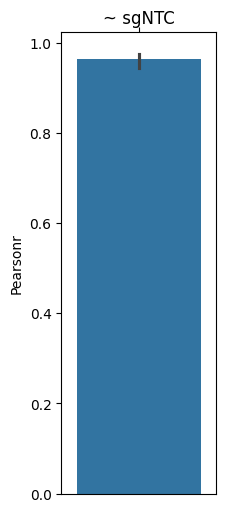

In [35]:
# calculate ntc correlation with guide
from scipy.stats import pearsonr
guide_corr = {}
for guide in gdata.var_names[gdata.var_names != "sgnon-targeting"]:
    p = pearsonr(pp_df.dropna()[guide], pp_df.dropna()["sgnon-targeting"])[0]
    guide_corr[guide] = p
r_df = pd.DataFrame(guide_corr, index=['Pearsonr'])
r_df = r_df.T.sort_values(by="Pearsonr")
plt.figure(figsize=(2, 6))
# plt.barh(r_df.columns, r_df.iloc[0], height=0.5, color="Grey")
sns.barplot(r_df, y='Pearsonr')
plt.xticks(rotation=90)
plt.title("~ sgNTC")
plt.show()

In [69]:
ntc_df.columns

Index(['1_0', '2_0', '3_0', '1_1', '2_1', '3_1', '1_2', '2_2', '3_2', '1_3',
       '2_3', '3_3', '1_4', '2_4', '3_4', '1_5', '2_5', '3_5', '1_6', '2_6',
       '3_6', '1_7', '2_7', '3_7', '1_8', '2_8', '3_8', '1_9', '2_9', '3_9',
       '1_10', '2_10', '3_10', '1_11', '2_11', '3_11'],
      dtype='object')

In [10]:
from scipy.stats import chi2_contingency

In [140]:
chi_df.columns.get_level_values(0)

Index(['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '2', '2',
       '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '3', '3', '3', '3',
       '3', '3', '3', '3', '3', '3', '3', '3'],
      dtype='object', name='marker')

In [136]:
chi_df.index_level != '1'

True

In [147]:
list([chi_df.loc[guide, (f'{i}', j)], chi_df.loc['sgnon-targeting', (f'{i}', j)]]), list([chi_df.loc[guide, (chi_df.columns.get_level_values(0) != f'{i}')].sum(),chi_df.loc['sgnon-targeting', chi_df.columns.get_level_values(0) != f'{i}'].sum()])

([0, 74], [3356, 14566])

In [169]:
chi_df

marker             1                                                  ...  \
cluster           0     1    2     3    4    5    6     7    8    9   ...   
sgAdrb2          177   629  181   383  309  110   42   390   43   65  ...   
sgAqp3            67   303  103   176  164   46   17   173   18   18  ...   
sgArntl           69   265   70   144  143   42   30   143   17   28  ...   
sgCd44             9    48   10    20   23    5    5    26    9    7  ...   
sgCd52           137   608  148   377  290  113   58   402   44   65  ...   
sgCxcl16          58   255   90   162  141   34   21   171   14   25  ...   
sgDdit3           91   349  107   217  188   70   35   228   25   41  ...   
sgErgic2          39   164   32   105   78   23   19   104   13   22  ...   
sgFbxo7           38   154   38    83   69   22    9    83    8   11  ...   
sgFlot1           76   344  103   207  175   59   40   186   20   32  ...   
sgGata3          467  1924  500  1115  932  335  164  1143  120  197  ...   
sgGlb1l2          56   202   65   122   98   35   29   111   19   24  ...   
sgGpa33           87   374   94   249  167   47   34   244   29   32  ...   
sgIkbip           46   192   48   106   88   26   16   115   10   14  ...   
sgKcna3           31   153   29   107   51   29   22    83   17   24  ...   
sgKlrd1          136   551  152   355  292  110   66   361   45   72  ...   
sgL3mbtl3         83   371  106   194  182   59   27   205   12   20  ...   
sgMark3          106   403  139   264  238   62   25   236   16   26  ...   
sgMcoln1          17    72   16    45   47   14   12    57    9   15  ...   
sgNmb             14    68   10    46   36   10    8    46    4    8  ...   
sgPiezo1          43   157   34   100   73   25   18   112   14   18  ...   
sgPomt1            5     4    4     7    1    1    0     7    0    2  ...   
sgPpia            58   288   42   185  101   58   61   199   29   61  ...   
sgS100a11         14    63   10    39   23   15    6    42    9   11  ...   
sgScamp4          86   341   78   236  168   68   46   211   31   55  ...   
sgSlc39a8         34   119   34    73   82   21   10    78   15   14  ...   
sgSorl1           91   441  120   272  217   67   36   250   27   39  ...   
sgSrgn            16    70   34    52   48   15    5    57    5   11  ...   
sgTmem64         135   553  139   300  266   85   54   350   35   63  ...   
sgWipf1           86   364  100   226  156   53   42   228   18   40  ...   
sgZc3h12a        107   495  151   308  239  119   52   299   29   52  ...   
sgZhx2           253  1101  309   629  545  194  101   677   86  124  ...   
sgZscan12         82   399  108   231  188   73   42   272   30   63  ...   
sgnon-targeting  376  1527  405   945  727  263  167   989  114  156  ...   

marker             3                                            
cluster           2    3    4    5   6    7    8   9   10   11  
sgAdrb2           13   15   15    6   1   12    4   1   5   28  
sgAqp3             4    1    1    0   3    3    0   1   3    7  
sgArntl            3    2    1    0   0    1    1   0   1    6  
sgCd44             1    1    0    0   0    1    0   0   0    0  
sgCd52            95   45   67   34   1   29   17   4  10  134  
sgCxcl16          57   30   43   31   0   20    9   0  14   99  
sgDdit3          455  223  352  208   4  109  122  10  60  692  
sgErgic2          61   20   50   27   0   27   14   1   5   86  
sgFbxo7           14   12    9    5   4   34    7   5   8   48  
sgFlot1           24    9   21   13   0   15    3   0   4   40  
sgGata3          192   90  148   83   5  104   48  10  36  308  
sgGlb1l2          60   31   37   20   2   18    9   2   4   69  
sgGpa33            3    1    1    0   3   16    1   0   0    4  
sgIkbip            1    2    0    3   0    1    0   0   1    2  
sgKcna3           95   38   72   38   0   26   18   3   9  125  
sgKlrd1            5    1    4    0   2    9    2   0   2    6  
sgL3mbtl3         64   28   61   23   1   30   18   1  13

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log2
  result = func(self.values, **kwargs)


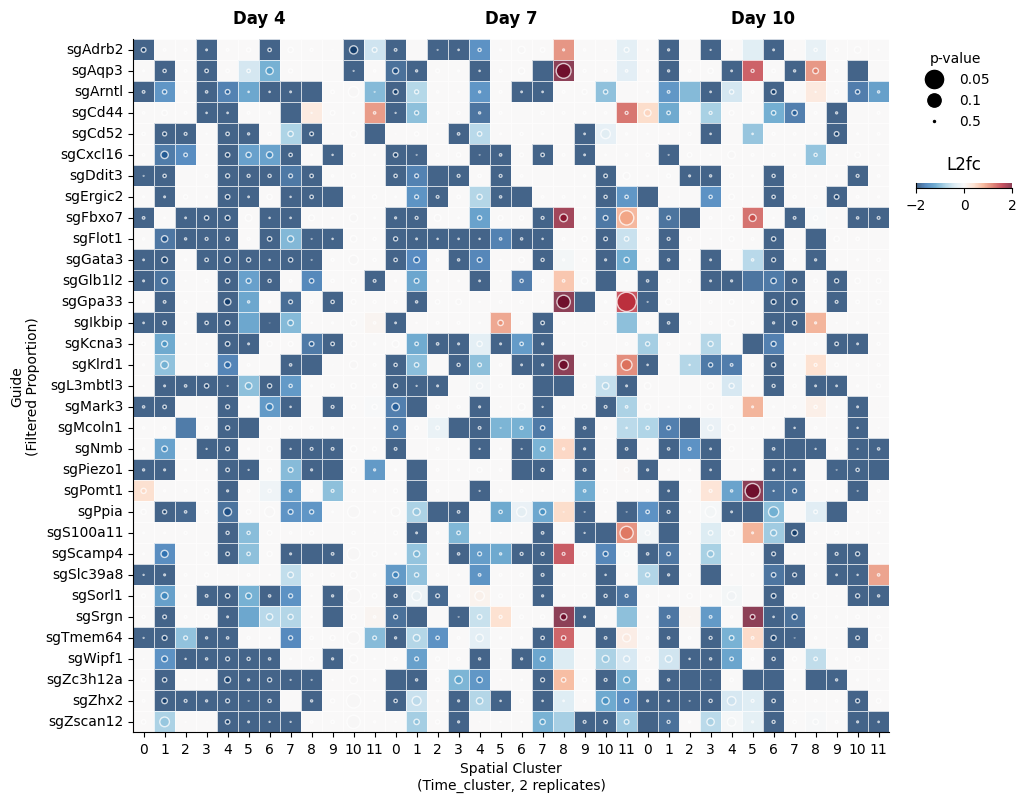

In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
from matplotlib.lines import Line2D
from scipy.stats import chi2_contingency

c_df = pd.DataFrame(gdata.X, columns=gdata.var_names)
c_df["marker"] = gdata.obs["marker"].str.split("-").str.get(0).tolist()
c_df["cluster"] = gdata.obs["cluster"].tolist()
c_df = c_df.groupby(["marker", "cluster"]).sum().unstack()

p_df = pd.DataFrame()
flag = False
for guide in np.unique(c_df.columns.get_level_values(0)):
    sum_v = c_df[guide].sum(axis=1)
    p_v = (c_df[guide].T / sum_v).T
    if not flag:
        p_df = pd.concat([p_df, p_v.reset_index().melt(id_vars="marker")], axis=1)
        flag = True
    else: p_df = pd.concat([p_df, p_v.reset_index().melt(id_vars="marker").value], axis=1)
pp_df = p_df.iloc[:, 2:]
pp_df.columns = np.unique(c_df.columns.get_level_values(0))
pp_df.index = [str(marker) + "_" + str(cluster) for marker, cluster in zip(p_df["marker"], p_df["cluster"])]

chi_df = c_df.unstack().unstack().unstack()
ntc_df = np.log2(pp_df.T / pp_df.loc[:, "sgnon-targeting"] + 1e-9)
pvalue_df = ntc_df.copy()

for guide in ntc_df.index:
    for i in range(1, 4):
        for j in range(12):
            if guide == 'sgnon-targeting': continue
            if chi_df.loc[guide, (f'{i}', j)] == 0:
                pvalue_df.loc[guide, f'{i}_{j}'] = 1
                # print(guide, i, j)
            else:
                pvalue_df.loc[guide, f'{i}_{j}'] = -np.log2(chi2_contingency([np.array([chi_df.loc[guide, (f'{i}', j)], chi_df.loc['sgnon-targeting', (f'{i}', j)]]),
                np.array([chi_df.loc[guide, (chi_df.columns.get_level_values(0) == f'{i}') & (chi_df.columns.get_level_values(1) != j)].sum(),
                    chi_df.loc['sgnon-targeting', (chi_df.columns.get_level_values(0) == f'{i}') & (chi_df.columns.get_level_values(1) != j)].sum()])]).pvalue)
                # print(pvalue_df.loc[guide, f'{i}_{j}'])

# Assume ntc_df and chi_df are already calculated
# Sample code that integrates your new request

# Set up the heatmap dimensions and background
plt.figure(figsize=(12, 12))

ntc_df = np.log2(ntc_df)
ntc_df.replace(-np.inf, 0, inplace=True)
ntc_df.fillna(0, inplace=True)

# Create a blank white background for the heatmap
sns.heatmap(ntc_df.iloc[:-1, :], cmap="RdBu_r", vmax=2, vmin=-2, cbar=False, 
            square=True, linewidths=.5, linecolor='white', alpha=0.75,
            annot=False, fmt="")

# Overlay the scatter plot to represent dots
# Create grid positions for each cell
x_positions, y_positions = np.meshgrid(np.arange(ntc_df.shape[1]) + 0.5, np.arange(ntc_df.shape[0]) + 0.5)

# Plot scatter points on top of the heatmap, using chi_df to control the size
# chi_df = np.abs(ntc_df)  # Assuming chi_df is derived or computed similarly, change this based on your needs
sizes = pvalue_df.values * 3.5  # Adjust scaling factor for dot size

# Use ntc_df values to determine color, and chi_df for size
scatter = plt.scatter(x_positions.ravel(), y_positions.ravel(), 
            c=ntc_df.values.ravel(), cmap="RdBu_r", 
            s=sizes.ravel(), edgecolor='white', linewidth=1, vmin=-2, vmax=2, alpha=0.75)

# Color legend (for ntc_df values)
cbar = plt.colorbar(scatter, orientation='horizontal', pad=0.1)  # Horizontal colorbar
cbar.ax.set_title('L2fc', pad=10)
cbar.outline.set_visible(False)  # Remove the colorbar border

# Shrink the colorbar and move it to the upper right corner
cbar.ax.set_position([0.85, 0.72, 0.08, 0.04])  # [left, bottom, width, height] in figure coordinates

# Adjust colorbar tick spacing
cbar.set_ticks(np.linspace(-2, 2, 3))

# Size legend (for chi_df values)
# Create a list of size values and corresponding labels for the size legend
size_legend_values = [0.05, 0.1, 0.5]  # Adjust these values as needed
size_legend_labels = [f"{val}" for val in size_legend_values]  # Convert to human-readable labels

# Create custom legend handles for size
size_handles = [Line2D([0], [0], marker='o', color='w', label=label, 
                       markerfacecolor='black', markersize=-np.log2(size) * 3.5, linewidth=0.5)
                for size, label in zip(size_legend_values, size_legend_labels)]

# Place the size legend
plt.legend(handles=size_handles, title="p-value", loc='upper right', bbox_to_anchor=(1.15, 1),
           frameon=False)  # Remove border

# Adjust plot aesthetics
# plt.title("Guide in Cluster/Time")
plt.ylabel("Guide\n(Filtered Proportion)")
plt.xlabel("Spatial Cluster\n(Time_cluster, 2 replicates)")
labels = []
days = ['Day 4', 'Day 7', 'Day 10']
for i in range(3):
    for j in range(12):
        labels.append(f'{j}')
# plt.gca().xticks(labels)
plt.gca().set_xticklabels(labels, rotation=0, ha='center')

# Coordinates for brackets (adjust as needed)
day_positions = [(0.5, 11.5), (12.5, 23.5), (24.5, 35.5)]
day_labels = ['Day 4', 'Day 7', 'Day 10']

for idx, (start, end) in enumerate(day_positions):
    # Draw a bracket
    con = ConnectionPatch(xyA=(start, -0.2), xyB=(end, -0.2), coordsA="data", coordsB="data",
                          axesA=plt.gca(), axesB=plt.gca(), color="black", lw=1)
    plt.gca().add_artist(con)
    # Add text label
    plt.gca().text((start + end) / 2, -1, day_labels[idx], ha="center", va="center", fontsize=12, fontweight='bold')
sns.despine()

plt.show()

In [84]:
old_data = sc.read_h5ad('./RNA/Multitime.guide.h5')
print(old_data.X.sum())

print(gdata.X.sum())

1613332
1613332


<Figure size 640x480 with 0 Axes>

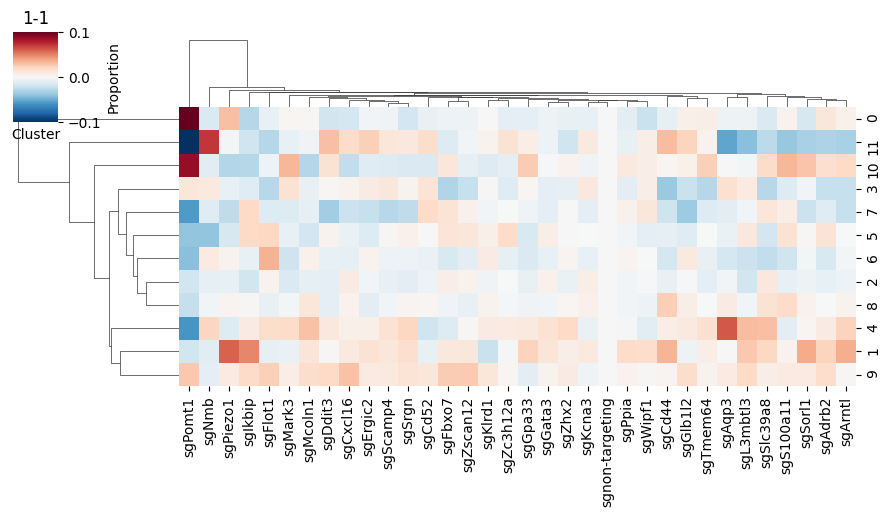

<Figure size 640x480 with 0 Axes>

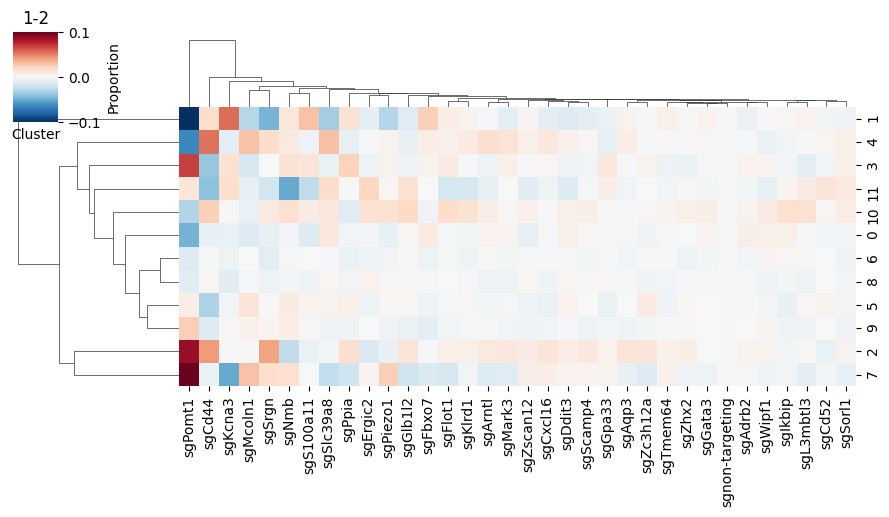

<Figure size 640x480 with 0 Axes>

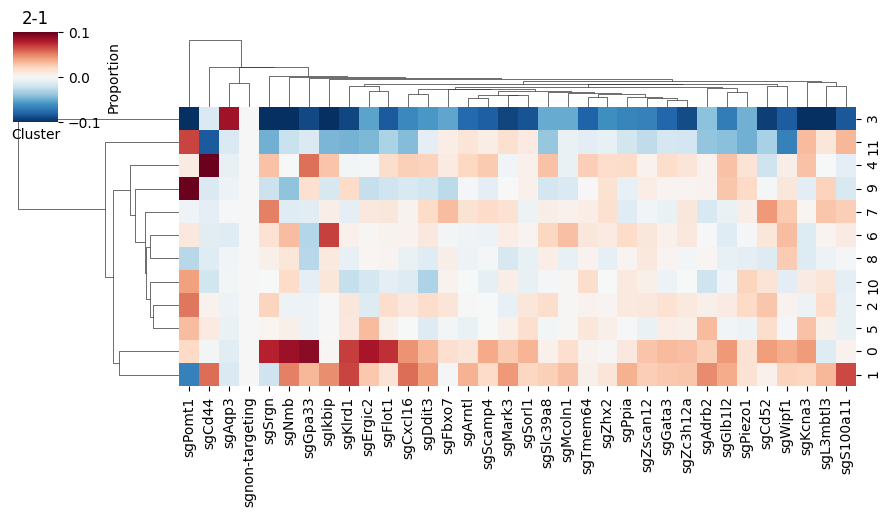

<Figure size 640x480 with 0 Axes>

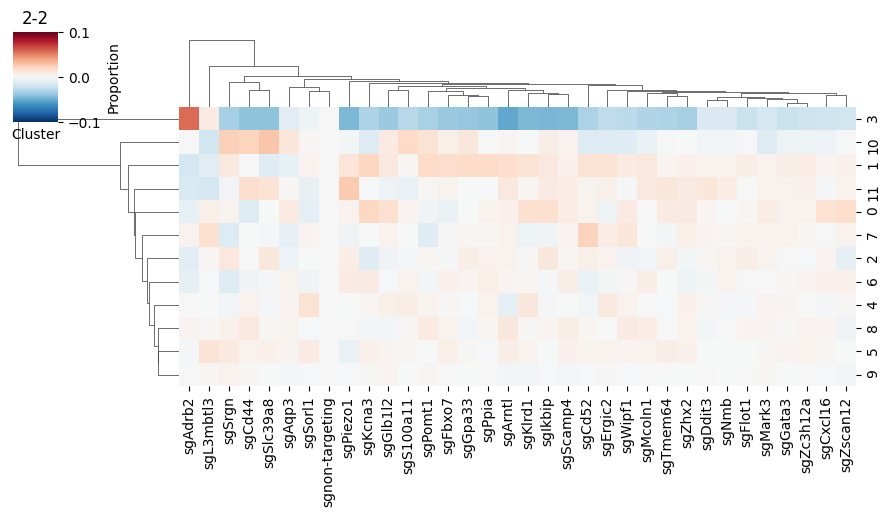

ValueError: The condensed distance matrix must contain only finite values.

<Figure size 640x480 with 0 Axes>

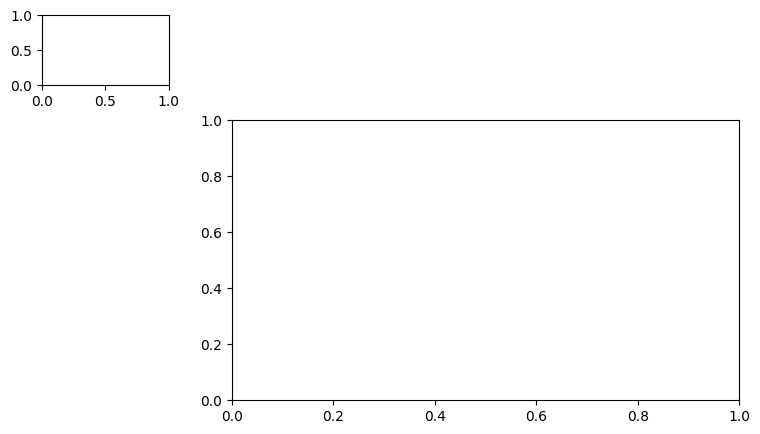

In [16]:
for marker in gdata.obs.marker.unique():
    gdata_ = gdata[gdata.obs.marker == marker].copy()
    c_df = pd.DataFrame(gdata_.X, columns=gdata_.var_names)
    c_df["cluster"] = gdata_.obs["cluster"].tolist()
    c_df = c_df.groupby(["cluster"]).sum()

    p_df = pd.DataFrame()
    for guide in np.unique(c_df.columns):
        sum_v = c_df[guide].sum()
        p_v = (c_df[guide].T / sum_v).T
        p_df = pd.concat([p_df, p_v], axis=1)

    p_df.columns = np.unique(c_df.columns)

    ntc_df = p_df.T - p_df.loc[:, "sgnon-targeting"]

    plt.figure()
    sns.clustermap(ntc_df.T, cmap="RdBu_r", vmax=0.1, figsize=(9, 5), vmin=-0.1)
    plt.colorbar.label = 'str'

    plt.title(f"{marker}")
    plt.ylabel("Proportion")
    plt.xlabel("Cluster")
    plt.show()

In [14]:
c_df = pd.DataFrame(gdata.X, columns=gdata.var_names)
c_df["cluster"] = gdata.obs["cluster"].tolist()
c_df = c_df.groupby(["cluster"]).sum()

chi_df = c_df.T.copy()

p_df = pd.DataFrame()
for guide in np.unique(c_df.columns):
    sum_v = c_df[guide].sum()
    p_v = (c_df[guide].T / sum_v).T
    p_df = pd.concat([p_df, p_v], axis=1)

p_df.columns = np.unique(c_df.columns)

ntc_df = np.log2(p_df.T / p_df.loc[:, "sgnon-targeting"] + 1e-9)
pvalue_df = ntc_df.copy()

for guide in chi_df.index:
    for j in range(12):
        if guide == 'sgnon-targeting': continue
        if chi_df.loc[guide, j] == 0:
            pvalue_df.loc[guide, j] = 1
        else:
            pvalue_df.loc[guide, j] = -np.log2(chi2_contingency([np.array([chi_df.loc[guide, j], chi_df.loc['sgnon-targeting', j]]),
            np.array([chi_df.loc[guide, (chi_df.columns != j)].sum(),
                chi_df.loc['sgnon-targeting', (chi_df.columns != j)].sum()])]).pvalue)

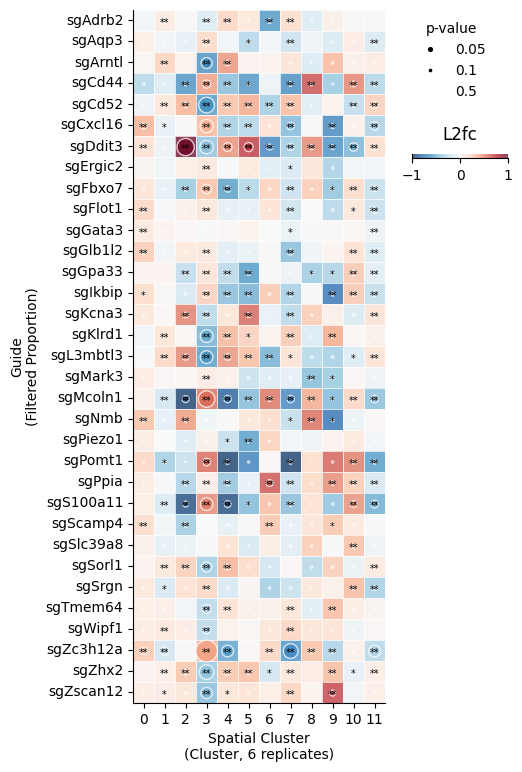

In [15]:
# Set up the heatmap dimensions and background
plt.figure(figsize=(12, 12))

# Create a blank white background for the heatmap
sns.heatmap(ntc_df.iloc[:-1, :], cmap="RdBu_r", vmax=1, vmin=-1, cbar=False, 
            square=True, linewidths=.5, linecolor='white', alpha=0.75,
            annot=False, fmt="")

# Overlay the scatter plot to represent dots
# Create grid positions for each cell
x_positions, y_positions = np.meshgrid(np.arange(ntc_df.shape[1]) + 0.5, np.arange(ntc_df.shape[0]) + 0.5)

# Plot scatter points on top of the heatmap, using chi_df to control the size
# chi_df = np.abs(ntc_df)  # Assuming chi_df is derived or computed similarly, change this based on your needs
sizes = pvalue_df.values * 1.1  # Adjust scaling factor for dot size

# Use ntc_df values to determine color, and chi_df for size
scatter = plt.scatter(x_positions.ravel(), y_positions.ravel()+0.05, 
            c=ntc_df.values.ravel(), cmap="RdBu_r", 
            s=sizes.ravel(), edgecolor='white', linewidth=1, vmin=-1, vmax=1, alpha=0.75)

for x, y, s in zip(x_positions.ravel(), y_positions.ravel() + 0.24, sizes.ravel()):
    if s/1.1 > -np.log2(0.05): plt.text(x, y, '**', ha='center', size=7)
    elif s/1.1 > -np.log2(0.1): plt.text(x, y, '*', ha='center', size=7)

# Color legend (for ntc_df values)
cbar = plt.colorbar(scatter, orientation='horizontal', pad=0.1)  # Horizontal colorbar
cbar.ax.set_title('L2fc', pad=10)
cbar.outline.set_visible(False)  # Remove the colorbar border

# Shrink the colorbar and move it to the upper right corner
cbar.ax.set_position([0.64, 0.73, 0.08, 0.03])  # [left, bottom, width, height] in figure coordinates

# Adjust colorbar tick spacing
cbar.set_ticks(np.linspace(-1, 1, 3))

# Size legend (for chi_df values)
# Create a list of size values and corresponding labels for the size legend
size_legend_values = [0.05, 0.1, 0.5]  # Adjust these values as needed
size_legend_labels = [f"{val}" for val in size_legend_values]  # Convert to human-readable labels

# Create custom legend handles for size
size_handles = [Line2D([0], [0], marker='o', color='w', label=label, 
                       markerfacecolor='black', markersize=-np.log2(size) * 1.1, linewidth=0.5)
                for size, label in zip(size_legend_values, size_legend_labels)]

# Place the size legend
plt.legend(handles=size_handles, title="p-value", loc='upper right', bbox_to_anchor=(1.45, 1),
           frameon=False)  # Remove border

# Adjust plot aesthetics
# plt.title("Guide in Cluster/Time")
plt.ylabel("Guide\n(Filtered Proportion)")
plt.xlabel("Spatial Cluster\n(Cluster, 6 replicates)")
labels = []
for j in range(12):
    labels.append(f'{j}')
# plt.gca().xticks(labels)
plt.gca().set_xticklabels(labels, rotation=0, ha='center')

sns.despine()

plt.rcParams['pdf.fonttype']=42
plt.savefig("./plots/Guide_Proportion_All.pdf", format="pdf", bbox_inches='tight')
plt.show()

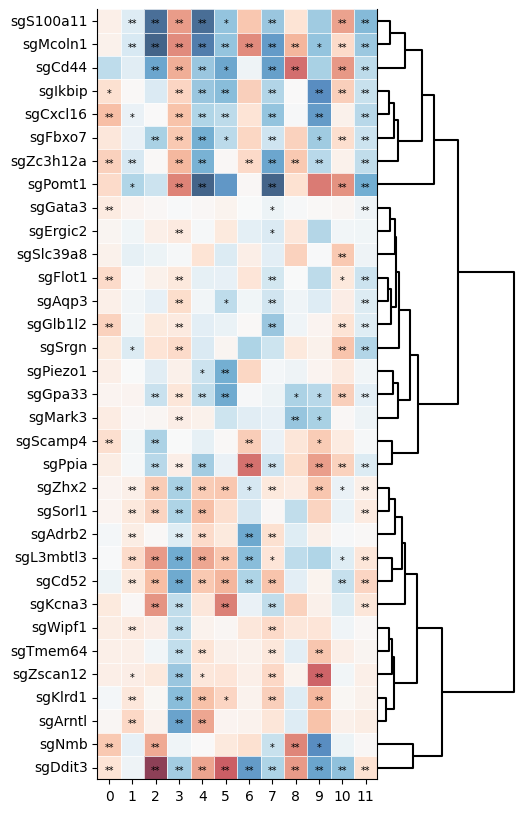

In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.cluster.hierarchy import dendrogram, linkage, leaves_list

# 1. Perform hierarchical clustering on the y-axis (guides)
linkage_matrix = linkage(ntc_df.iloc[:-1, :], method='ward')

# 2. Create a dendrogram and get the order of the rows (leaves)
fig, ax = plt.subplots(1, 2, figsize=(12, 10), gridspec_kw={'width_ratios': [9, 1], 'wspace': -0.705})  # Adjust the figure layout
dendro = dendrogram(linkage_matrix, orientation='right', ax=ax[1], color_threshold=0, above_threshold_color='black')

# Adjust the appearance of the dendrogram
ax[1].set_yticks([])  # Hide y-ticks for dendrogram
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)

# Get the order of the leaves (rows) from the dendrogram
ordered_leaves = leaves_list(linkage_matrix)[::-1]

# 3. Reorder ntc_df and pvalue_df based on the hierarchical clustering results on the y-axis
ntc_df_clustered = ntc_df.iloc[ordered_leaves, :]
pvalue_df_clustered = pvalue_df.iloc[ordered_leaves, :]

# 4. Plot the heatmap using the reordered ntc_df (clustered on y-axis)
sns.heatmap(ntc_df_clustered, cmap="RdBu_r", vmax=1, vmin=-1, cbar=False, 
            square=True, linewidths=.5, linecolor='white', alpha=0.75, 
            annot=False, fmt="", ax=ax[0])

# 5. Overlay the scatter plot to represent dots
x_positions, y_positions = np.meshgrid(np.arange(ntc_df_clustered.shape[1]) + 0.5, 
                                       np.arange(ntc_df_clustered.shape[0]) + 0.5)

# Adjust the scatter point sizes based on pvalue_df values
sizes = pvalue_df_clustered.values * 1.1  # Adjust scaling factor for dot size
sizes_flat = sizes.ravel()  # Ensure sizes array matches the length of x_positions and y_positions

# Plot scatter points on top of the heatmap, using ntc_df values for color, and pvalue_df for size
# scatter = ax[0].scatter(x_positions.ravel(), y_positions.ravel() + 0.05, 
#                         c=ntc_df_clustered.values.ravel(), cmap="RdBu_r", 
#                         s=sizes_flat, edgecolor='white', linewidth=1, vmin=-1, vmax=1, alpha=0.75)

# 6. Add stars for significance based on pvalue thresholds
for x, y, s in zip(x_positions.ravel(), y_positions.ravel() + 0.24, sizes_flat):
    if s / 1.1 > -np.log2(0.05):
        ax[0].text(x, y, '**', ha='center', size=7)
    elif s / 1.1 > -np.log2(0.1):
        ax[0].text(x, y, '*', ha='center', size=7)

# 7. Add horizontal colorbar for ntc_df values
# cbar = plt.colorbar(scatter, orientation='horizontal', pad=0.1, ax=ax[0])
# cbar.ax.set_title('L2fc', pad=10)
# cbar.outline.set_visible(False)  # Remove the colorbar border
# cbar.ax.set_position([0.64, 0.73, 0.08, 0.03])  # Shrink and position the colorbar
# cbar.set_ticks(np.linspace(-1, 1, 3))  # Adjust colorbar tick spacing

# 8. Create a size legend for p-values
# size_legend_values = [0.05, 0.1, 0.5]  # Adjust as needed
# size_legend_labels = [f"{val}" for val in size_legend_values]

# # Create custom legend handles for size
# size_handles = [Line2D([0], [0], marker='o', color='w', label=label, 
#                        markerfacecolor='black', markersize=-np.log2(size) * 1.1, linewidth=0.5)
#                 for size, label in zip(size_legend_values, size_legend_labels)]

# # Place the size legend
# ax[0].legend(handles=size_handles, title="p-value", loc='upper right', bbox_to_anchor=(1.2, 1),
#              frameon=False)  # Remove border

# Remove unnecessary plot borders
# sns.despine()
ax[1].set_xticks([])
ax[0].spines['bottom'].set_visible(True)
ax[0].spines['left'].set_visible(True)

# Save the final plot
plt.savefig("./plots/Guide_Proportion_All.pdf", format="pdf", bbox_inches='tight')
plt.show()

In [15]:
gdata_ = gdata[gdata.obs.marker == "2-1"].copy()

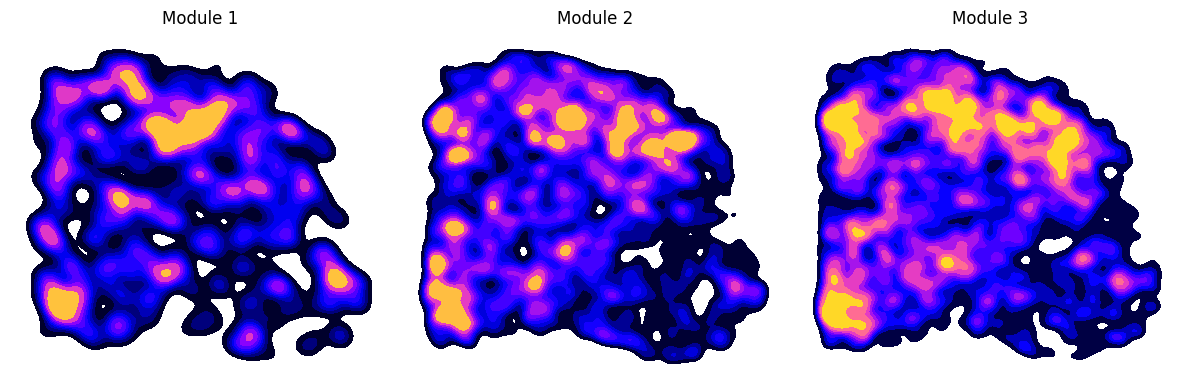

In [18]:
for module in modeul_dict.keys():
    gdata.obs[f"{module}_score"] = gdata[:, modeul_dict[module]].X.sum(axis=1)
gdata.obs['x'] = gdata.obsm['spatial'][:, 0]
gdata.obs['y'] = gdata.obsm['spatial'][:, 1]
_, ax = plt.subplots(1, 3, figsize=(12, 4))
for i, module in enumerate(modeul_dict.keys()):
    # sq.pl.spatial_scatter(gdata[gdata.obs.marker == "B926-1"], color=f"{module}_score", shape=None, size=10, library_id='spatial', ax=ax[i//2, i%2], colorbar=False)
    
    # scatter = sns.scatterplot(gdata[(gdata.obs.marker == "B926-1")  & (gdata.obs[f'{module}_score'] > 0)].obs, x='x', y='y',
                    # hue=f"{module}_score", size=10, ax=ax[i//2, i%2], palette='flare', edgecolor='none')
    scatter = sns.kdeplot(gdata[(gdata.obs.marker == "2-1")  & (gdata.obs[f'{module}_score'] > 0)].obs, x='x', y='y',
                    weights=f"{module}_score", ax=ax[i], cmap='gnuplot2', fill=True, bw_adjust=0.3)
    # scatter.set_facecolor('black')
    scatter.set_xticks([])
    scatter.set_yticks([])
    scatter.set_xlabel('')
    scatter.set_ylabel('')
    scatter.set_title(f"{module}")
    scatter.invert_yaxis()
plt.subplots_adjust(hspace=0.4, wspace=0.4)  # 调整ax之间的间距
plt.tight_layout()

sns.despine(left=True, bottom=True)

plt.rcParams['pdf.fonttype']=42
plt.savefig("./plots/Module_Proportion_Contour.pdf", format="pdf", bbox_inches='tight')
plt.show()

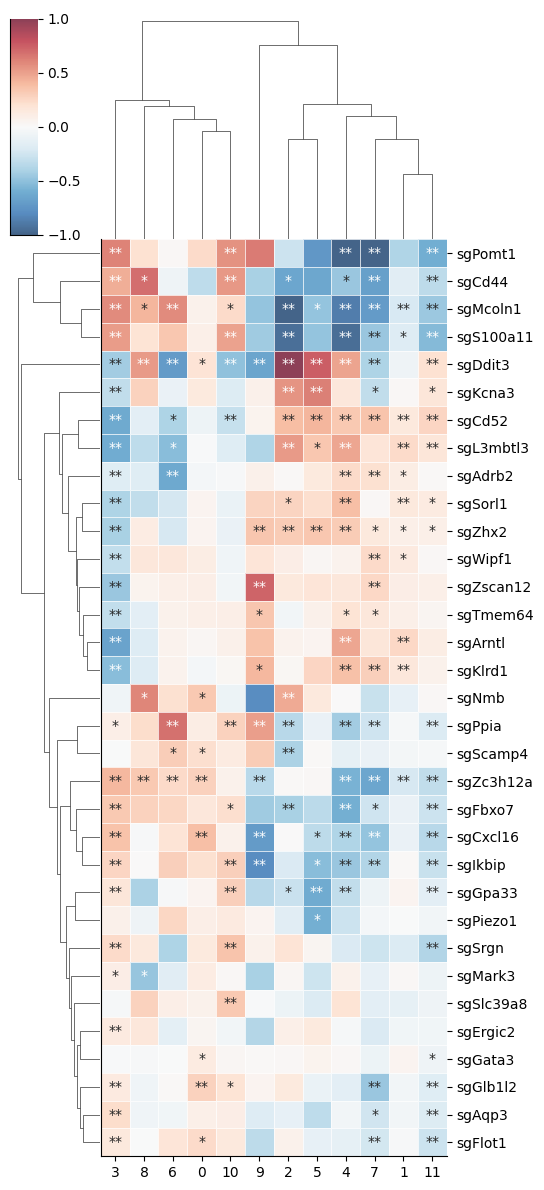

In [17]:
p_df = pvalue_df.map(lambda x: '**' if x > -np.log2(0.01) else ('*' if x > -np.log2(0.05) else ''))
sns.clustermap(ntc_df.iloc[:-1, :], cmap="RdBu_r", vmax=1, vmin=-1, cbar=True, 
            square=False, linewidths=.5, linecolor='white', alpha=0.75,
            annot=p_df.iloc[:-1, :], fmt="s", figsize=(5.5,12))
sns.despine()
# plt.savefig("./plots/Guide_Proportion_All.pdf", format="pdf", bbox_inches='tight')
# plt.show()

<Figure size 1200x600 with 0 Axes>

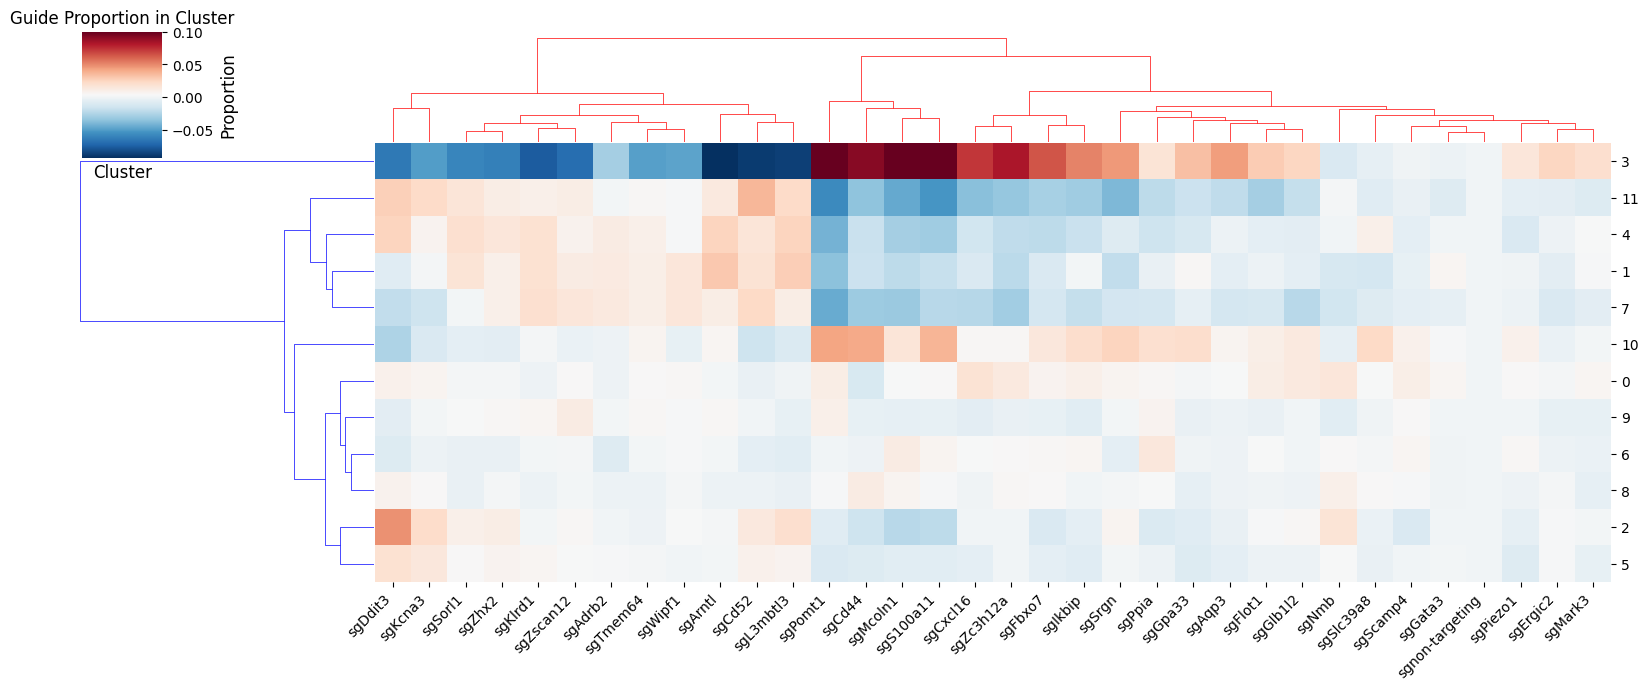

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sample data
# ntc_df = pd.DataFrame(...)  # Assume ntc_df is already defined

# Create the clustermap
plt.figure(figsize=(12, 6))
clustermap = sns.clustermap(ntc_df.T, cmap="RdBu_r", vmax=0.1, figsize=(16, 7))

# Customize the appearance
# Change the color of the dendrogram
for i, line in enumerate(clustermap.ax_col_dendrogram.collections):
    line.set_color('red')  # Change to your preferred color

for i, line in enumerate(clustermap.ax_row_dendrogram.collections):
    line.set_color('blue')  # Change to your preferred color

# Rotate x and y tick labels
clustermap.ax_heatmap.set_xticklabels(clustermap.ax_heatmap.get_xticklabels(), rotation=45, ha='right')
clustermap.ax_heatmap.set_yticklabels(clustermap.ax_heatmap.get_yticklabels(), rotation=0)

# Set the colorbar title
colorbar = clustermap.ax_heatmap.collections[0].colorbar
colorbar.set_label('Guide Proportion')

# Set titles and labels
plt.title("Guide Proportion in Cluster", fontsize=12)
plt.ylabel("Proportion", fontsize=12)
plt.xlabel("Cluster", fontsize=12)

# Show the plot
plt.show()


# Guide Correlation

In [33]:
sgs = guide_data.var_names.str.split('_', n=1).str[0]
sgs_grouped = pd.DataFrame(guide_data.X, columns=guide_data.var_names)
sgs_grouped = sgs_grouped.groupby(sgs, axis=1).sum()
sgdata = ad.AnnData(sgs_grouped, obs=guide_data.obs, var=pd.DataFrame(index=sgs_grouped.columns))
sgdata.obsm['spatial'] = guide_data.obsm['spatial']
gdata = sgdata.copy()

/tmp/ipykernel_15269/32191674.py:3: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  sgs_grouped = sgs_grouped.groupby(sgs, axis=1).sum()


In [34]:
from scipy.stats import spearmanr
from scipy.stats import pearsonr

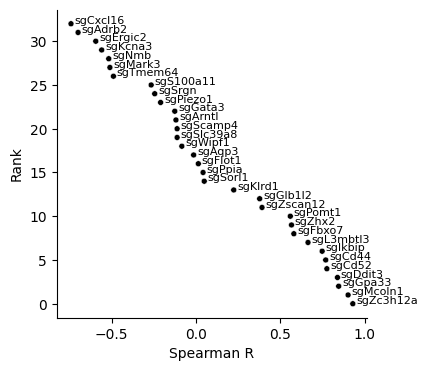

In [74]:
p_df = {}
do_df = ntc_df.T
for guide in gdata.var_names.str.split('_').str.get(0).unique().tolist():
    if guide != "sgnon-targeting":
        p = spearmanr(do_df.loc[:, guide + "_1_gene"], do_df.loc[:, guide + "_2_gene"])[0]
        # p_ = pearsonr(do_df.loc[:, guide + "_1_gene"], do_df.loc[:, guide + "_2_gene"])[0]
        p_df[guide] = {
            "spearmanr": p,
            # "pearsonr": p_
        }
p_df = pd.DataFrame(p_df).T.sort_values(by='spearmanr', ascending=False)
plt.figure(figsize=(4, 4))
# plt.imshow(p_df, cmap='RdBu_r', aspect='auto')
p_df['rank'] = list(range(p_df.shape[0]))

sns.scatterplot(p_df, x='spearmanr', y='rank', color='black', size=10, legend=False)

# plt.colorbar()
# plt.yticks(np.arange(p_df.shape[0]), p_df.index)
plt.xlabel('Spearman R')
plt.ylabel('Rank')

# # 在每个单元格中标注数据
# for i in range(p_df.shape[0]):
#     for j in range(p_df.shape[1]):
#         plt.text(j, i, f'{p_df.iloc[i, j]:.2f}', ha='center', va='center', color='white')
for i in range(p_df.shape[0]):
    plt.text(x=p_df.iloc[i, 0] + 0.02, s=p_df.index[i], y=i + 0.02, size=8)

plt.title('')
sns.despine()
plt.rcParams['pdf.fonttype']=42
plt.savefig("./plots/cluster_correlation_rep.pdf", format="pdf", bbox_inches='tight')
plt.show()